In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.metrics import hamming_loss
import seaborn as sns

In [2]:
def scaleMatrix(matrix):
    return matrix.div(matrix.sum(axis=1),axis=0)

In [3]:
def norm(series):
    b = max(series)
    a = min(series)
    return [(x - a) / (b - a) for x in series]

In [4]:
def npmc(init_state, matrix, original_states, init_state_col):
    matrix = scaleMatrix(matrix)
    probs = {k:list(matrix.iloc[original_states.index(k)]) for k in original_states}
    NewState = []
    for x in range(len(init_state)):
        NewState.append(np.random.choice(a = matrix.columns, p = probs[init_state[init_state_col][x]],size=1)[0])
    NextStep = pd.DataFrame()
    NextStep["Original State"] = init_state[init_state_col]
    NextStep["New State"] = NewState
    return NextStep

In [5]:
def chain(init_state, matrix, original_states, init_state_col,n):
    init_state = init_state.copy()
    out = pd.DataFrame()
    out[0] = init_state[init_state_col]
    for i in range(1,n+1):
        out[i] = npmc(out,matrix,original_states,i-1)["New State"]
    return out

In [6]:
def proj(inp,X1,X2,n,start_state_col):
    sts = []
    inp.reset_index(drop = True,inplace = True)
    curr_st = inp[start_state_col].iloc[0]
    for step in range(n):
        sts.append(curr_st)
        if curr_st == -1:
            try:
                up_prob = npdfd["t1"].iloc[downknn.kneighbors([[inp[X1][step],inp[X2][step]]],n_neighbors,False)[0]].value_counts()[1] / n_neighbors
            except:
                up_prob = 0
            try:
                down_prob = npdfd["t1"].iloc[downknn.kneighbors([[inp[X1][step],inp[X2][step]]],n_neighbors,False)[0]].value_counts()[0] / n_neighbors
            except:
                down_prob = 1- up_prob
            curr_st = np.random.choice([0,1],1,p = [down_prob, up_prob])[0]
        else:
            try:
                up_prob = npdfu["t1"].iloc[upknn.kneighbors([[inp[X1][step],inp[X2][step]]],n_neighbors,False)[0]].value_counts()[1] / n_neighbors
            except:
                up_prob = 0
            try:
                down_prob = npdfu["t1"].iloc[upknn.kneighbors([[inp[X1][step],inp[X2][step]]],n_neighbors,False)[0]].value_counts()[0] / n_neighbors
            except:
                down_prob = 1 - up_prob
            curr_st = np.random.choice([0,1],1,p = [down_prob, up_prob])[0]
    return sts

In [7]:
tick = pd.read_csv("NASDAQ_Ticks.csv")
all_data = {}
all_tm = {}
returns = {}
for x in tick["Ticker"]:
    
    df = pd.DataFrame()
    t0 = pd.read_csv(x+".csv")["Adj Close"]
    returns[x] = t0.pct_change().iloc[::3][1:]
    df["MMYYYY"] = [x[5:7] + x[:4] for x in pd.read_csv(x+".csv")["Date"][1:]]
    df.reset_index(drop = True,inplace = True)
    df["t0"] = np.where(t0.pct_change()[1:] > 0, 1, 0)
    df.dropna(inplace=True)
    df.reset_index(drop = True,inplace = True)
    
    df["t1"] = df["t0"].shift(-3)
    df.dropna(inplace=True)
    df.reset_index(drop = True,inplace = True)
    
    states = ["Up","Down"]
    TM = pd.DataFrame(index = ["Up","Down"])
    
    tm = {"UU":0,"UD":0,"DU":0,"DD":0}
    
    for i in range(2,len(df)):
        
        if df["t0"][i] == 1 and df["t0"][i-1] == 1:
            tm["UU"] += 1
        elif df["t0"][i] == 0 and df["t0"][i-1] == 1:
            tm["UD"] += 1
        elif df["t0"][i] == 1 and df["t0"][i-1] == 0:
            tm["DU"] += 1
        else:
            tm["DD"] += 1
            
    TM["Up"] = [tm["UU"],tm["UD"]]
    TM["Down"] = [tm["DU"],tm["DD"]]
    
    findf = pd.read_csv(x + "_quarterly_valuation_measures.csv",header=None).T
    findf.columns = findf.iloc[0]
    findf.drop([0,1],inplace=True)
    
    findf1 = pd.DataFrame()
    findf1["MMYYYY"] = [y[:2]+ y[6:10] for y in findf["name"].str.replace('/', '-')]
    try:
        findf1["PeRatio"] = np.log(findf["PeRatio"].str.replace(',', '').astype(float))
    except:
        findf1["PeRatio"] = np.log(findf["PegRatio"].str.replace(',', '').astype(float)*0.18)
    findf1['MarketCap'] = np.log(findf['MarketCap'].str.replace(',', '').astype(float))
    findf1.interpolate(method='linear',inplace=True)
    
    findf1.dropna(inplace=True)
    findf1.reset_index(drop = True,inplace = True)
    
    alldf = df.merge(right=findf1, on = ["MMYYYY"])
    if len(alldf) > 40:
        all_tm[x] = scaleMatrix(TM)
        all_data[x] = alldf
len(all_data)

84

In [8]:
npdf = pd.DataFrame()
tk = []
my = []
t0 = []
t1 = []
ps = []
mc = []
for x in all_data.keys():
    tk.extend([x for y in range(len(all_data[x]))])
    my.extend([x for x in all_data[x]["MMYYYY"]])
    t0.extend([x for x in all_data[x]["t0"]])
    t1.extend([x for x in all_data[x]["t1"]])
    ps.extend([x for x in all_data[x]["PeRatio"]])
    mc.extend([x for x in all_data[x]["MarketCap"]])
npdf["Ticker"] = tk
npdf["MMYYYY"] = my
npdf["t0"] = t0
npdf["t1"] = t1
npdf["PeRatio"] = ps
npdf["MarketCap"] = mc

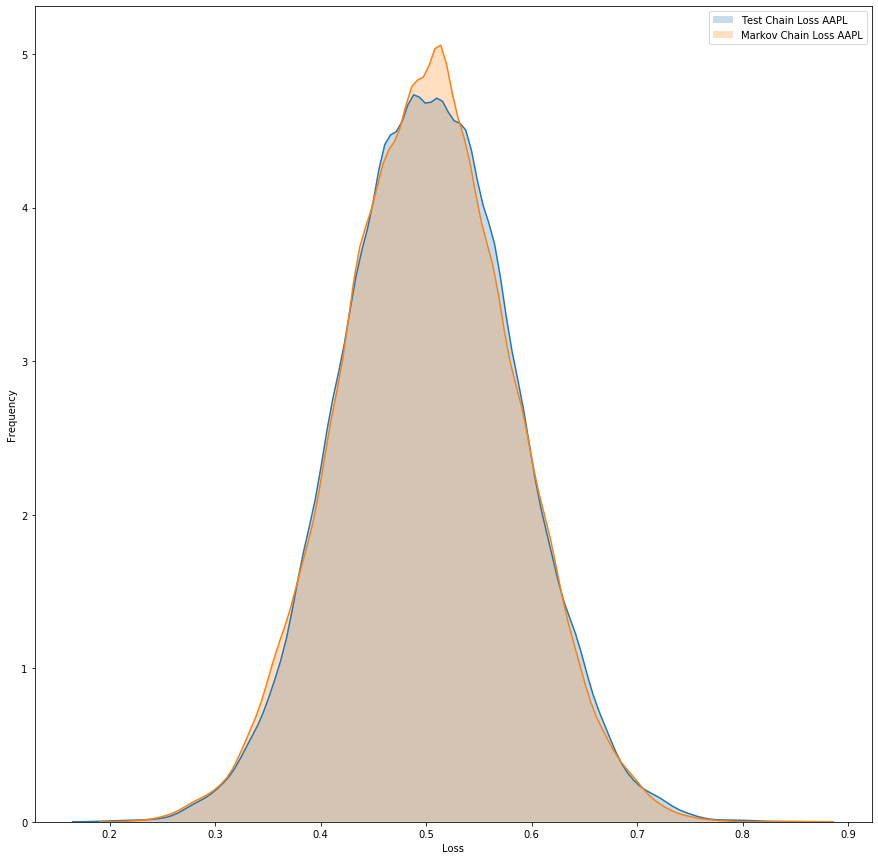

1.1904761904761905% done!


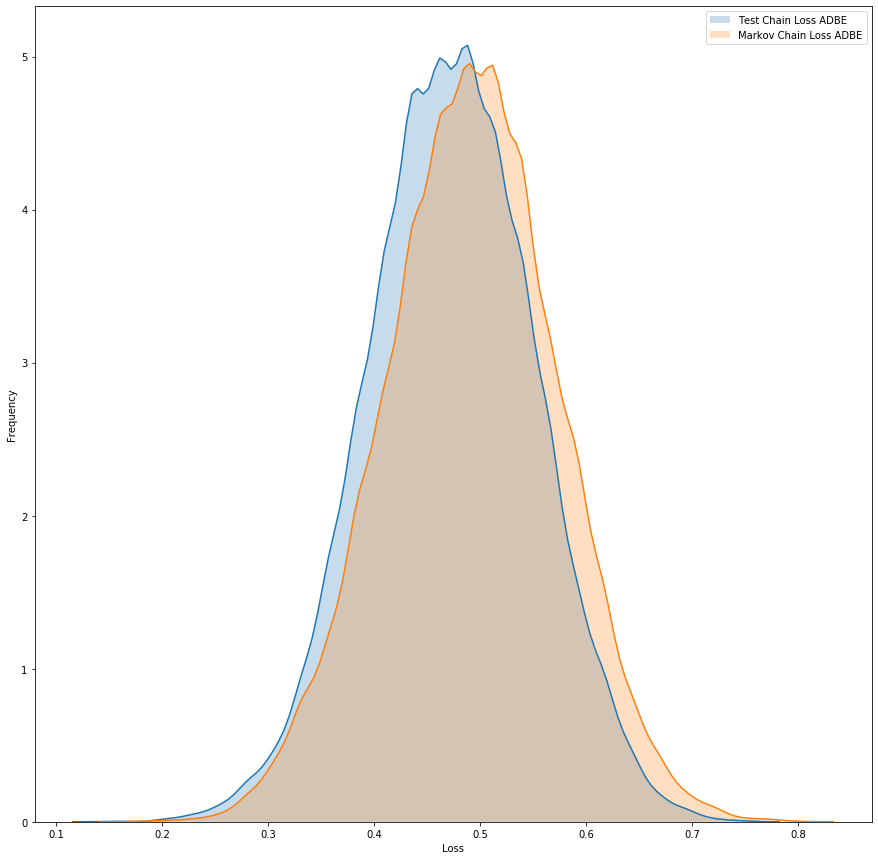

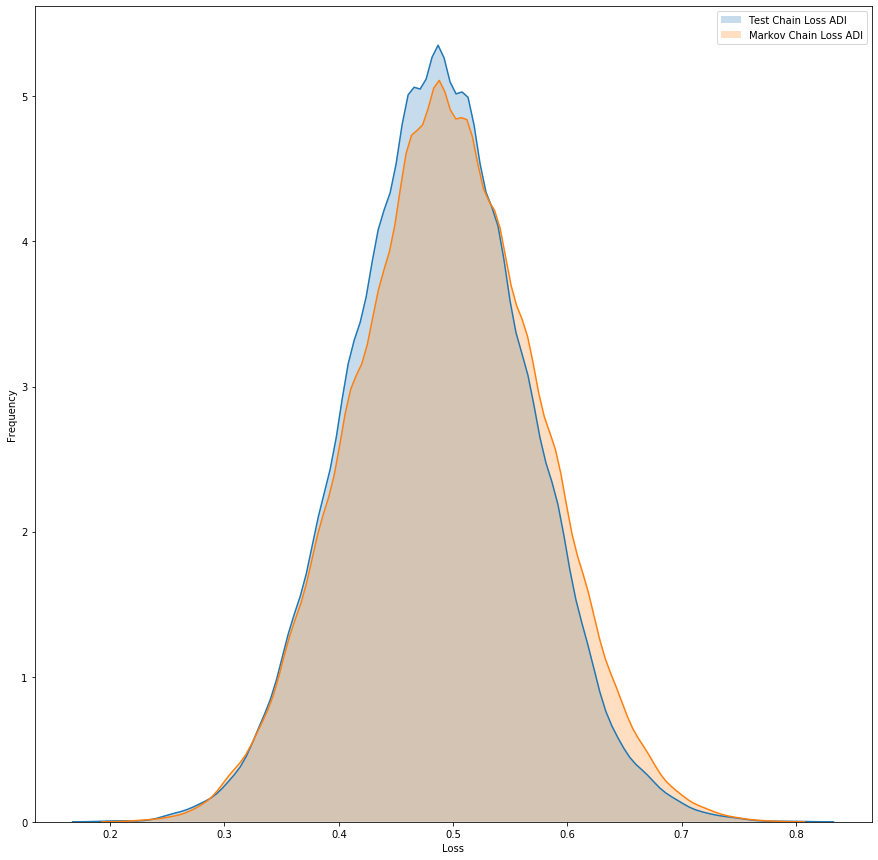

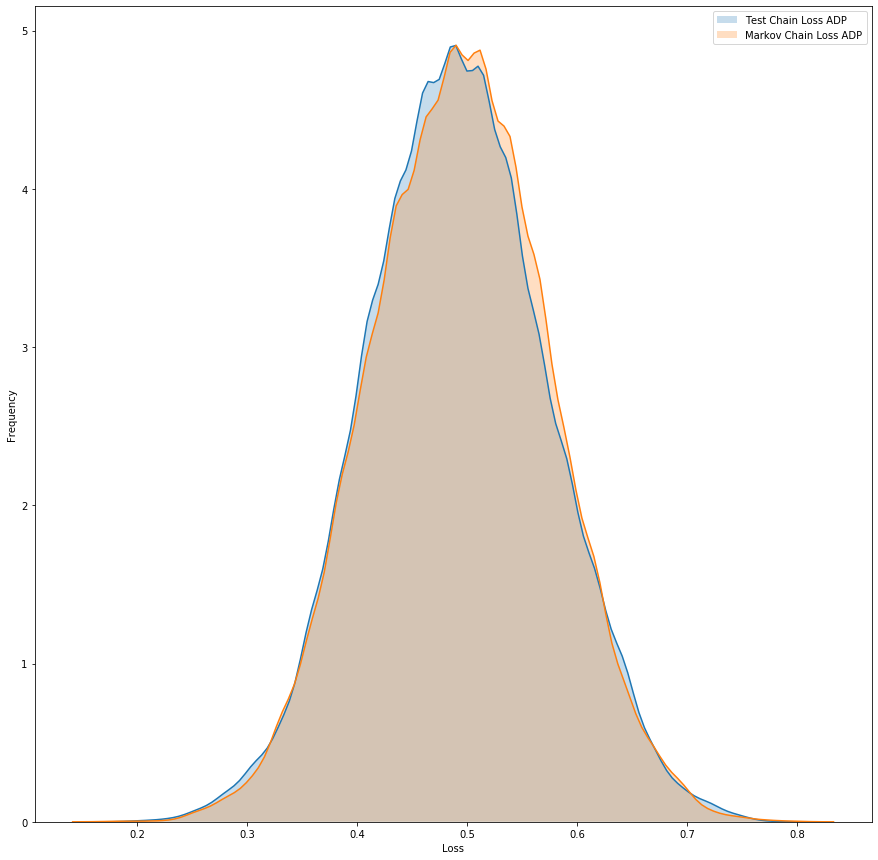

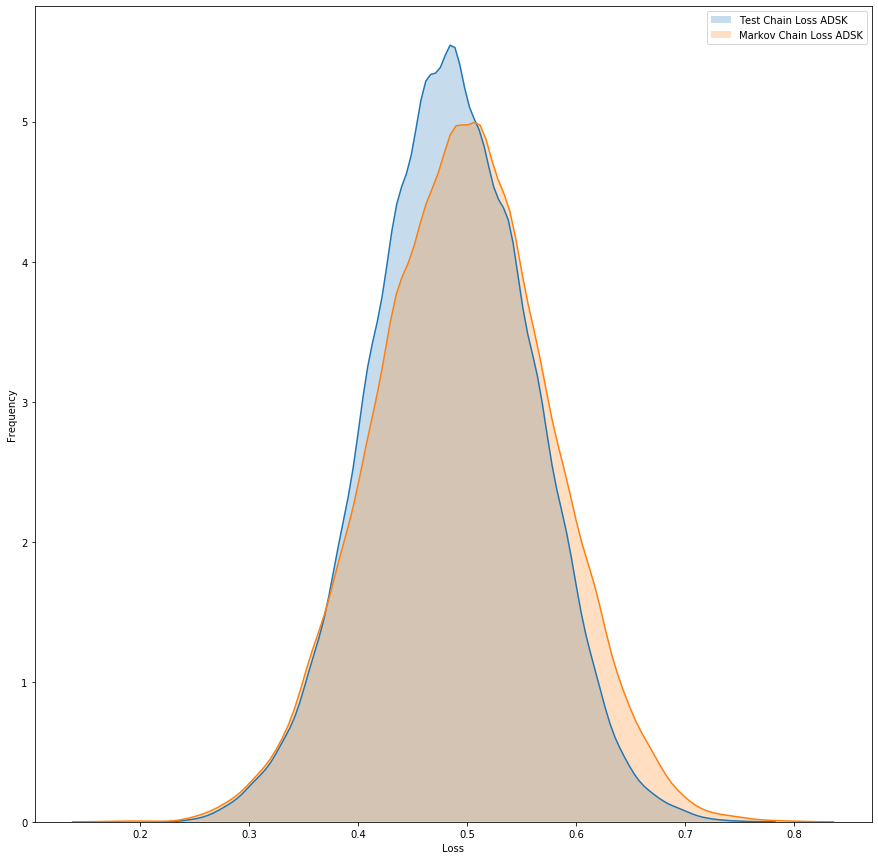

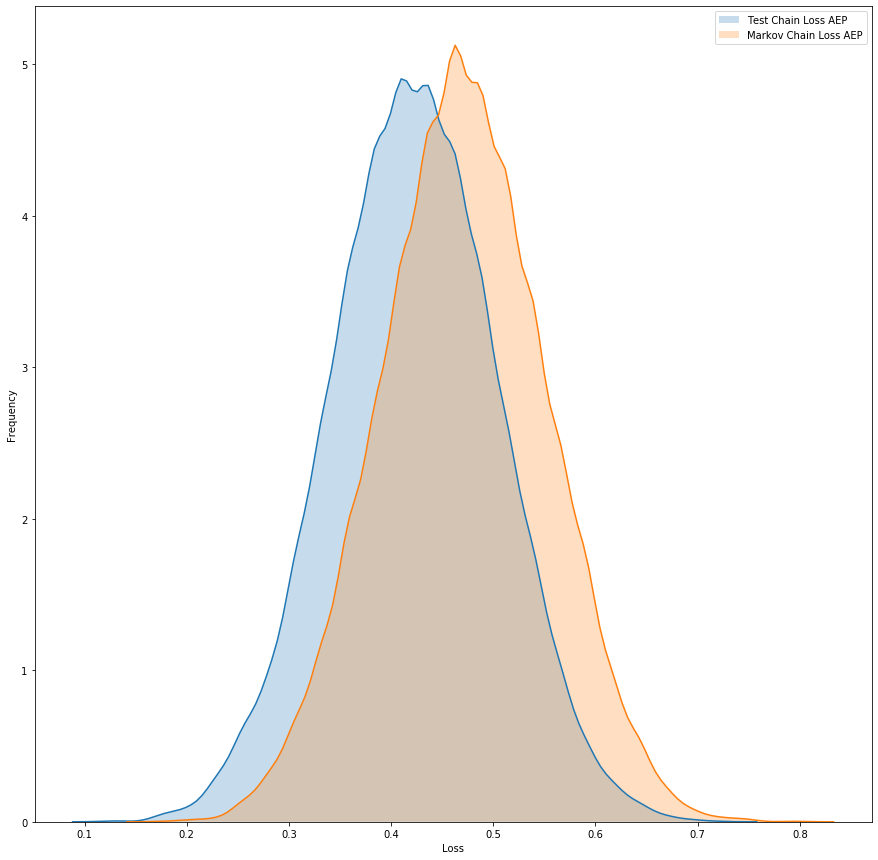

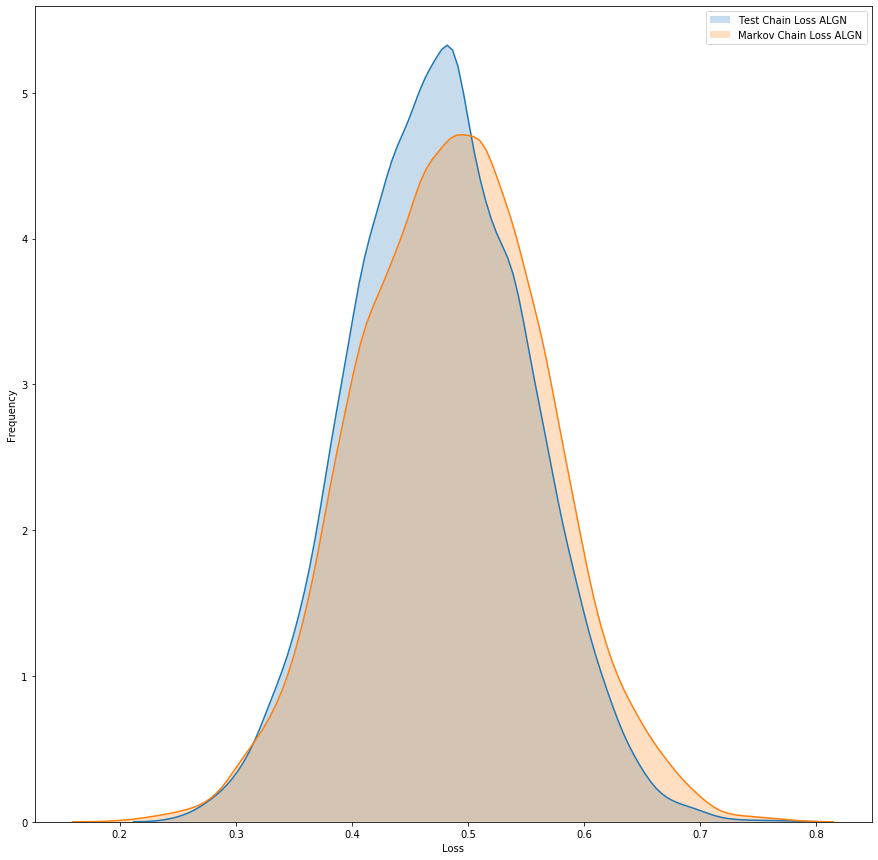

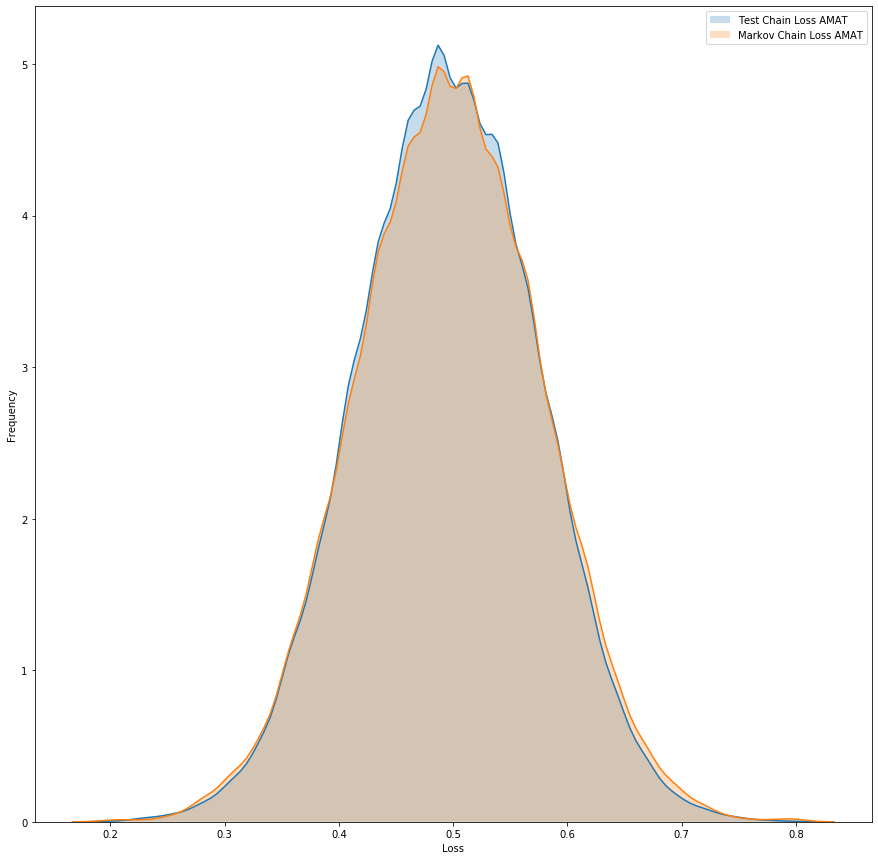

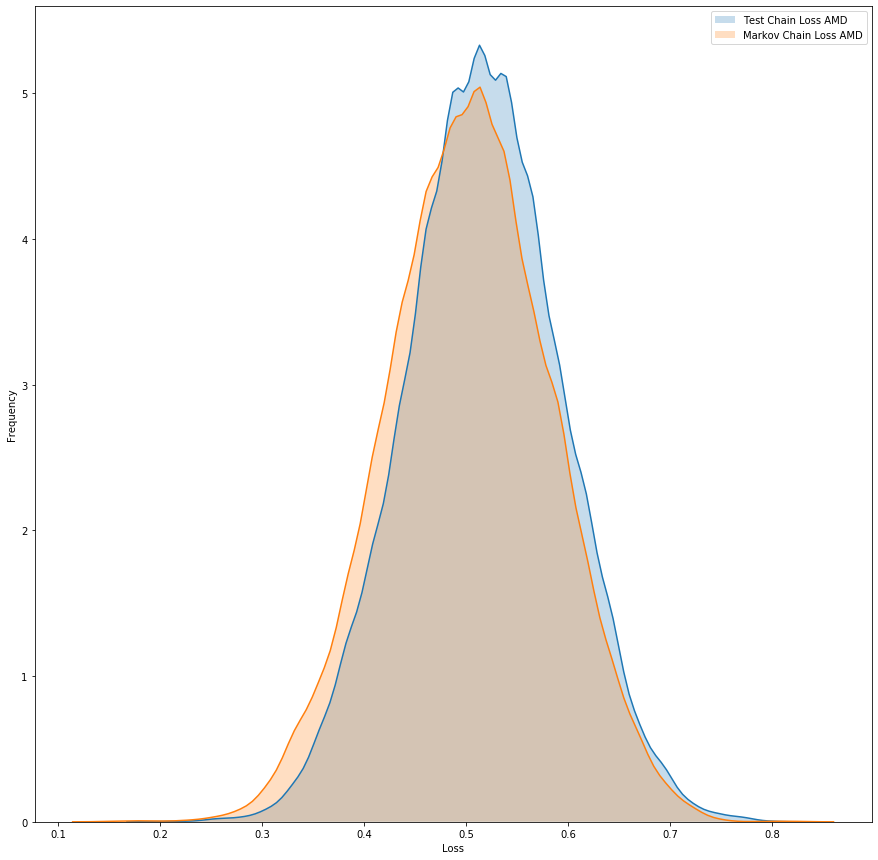

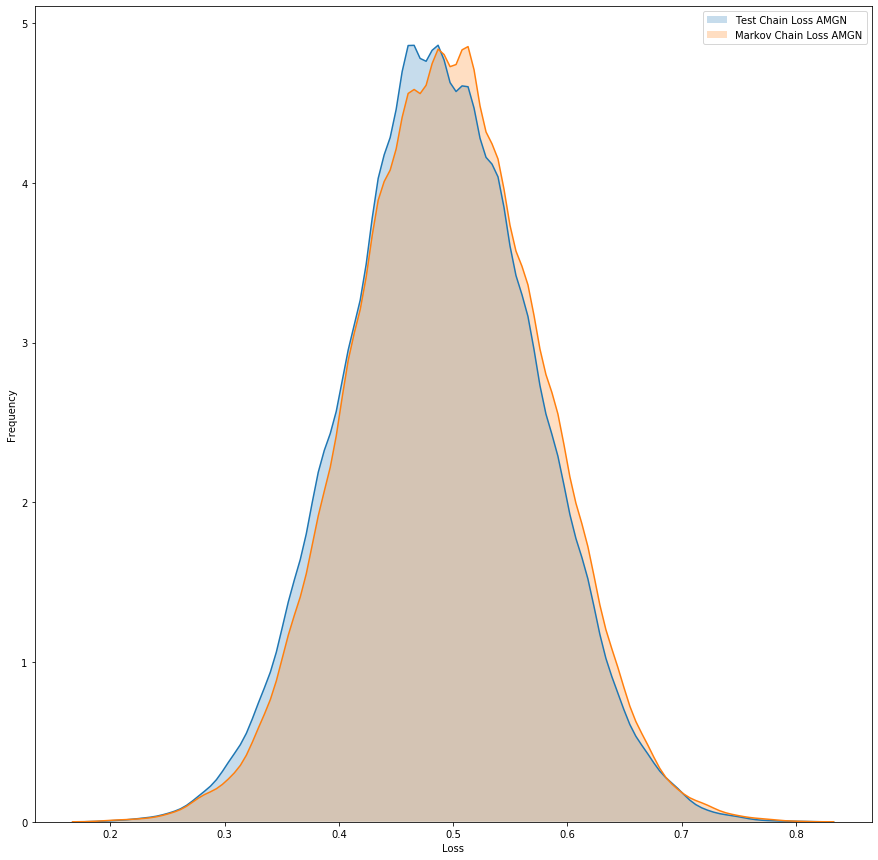

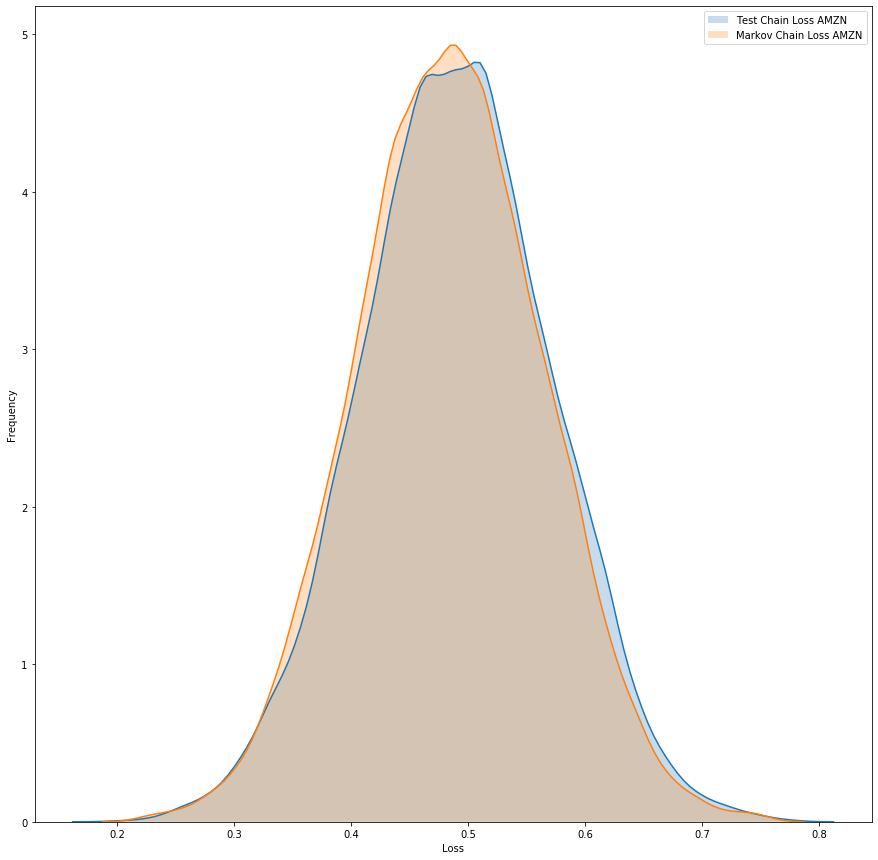

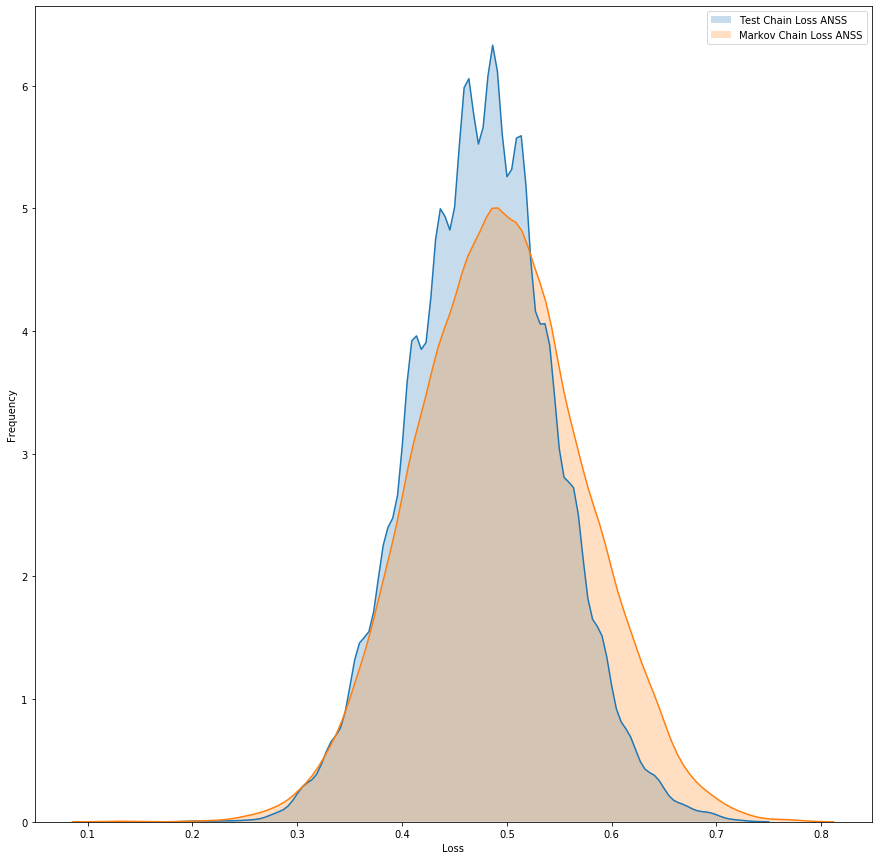

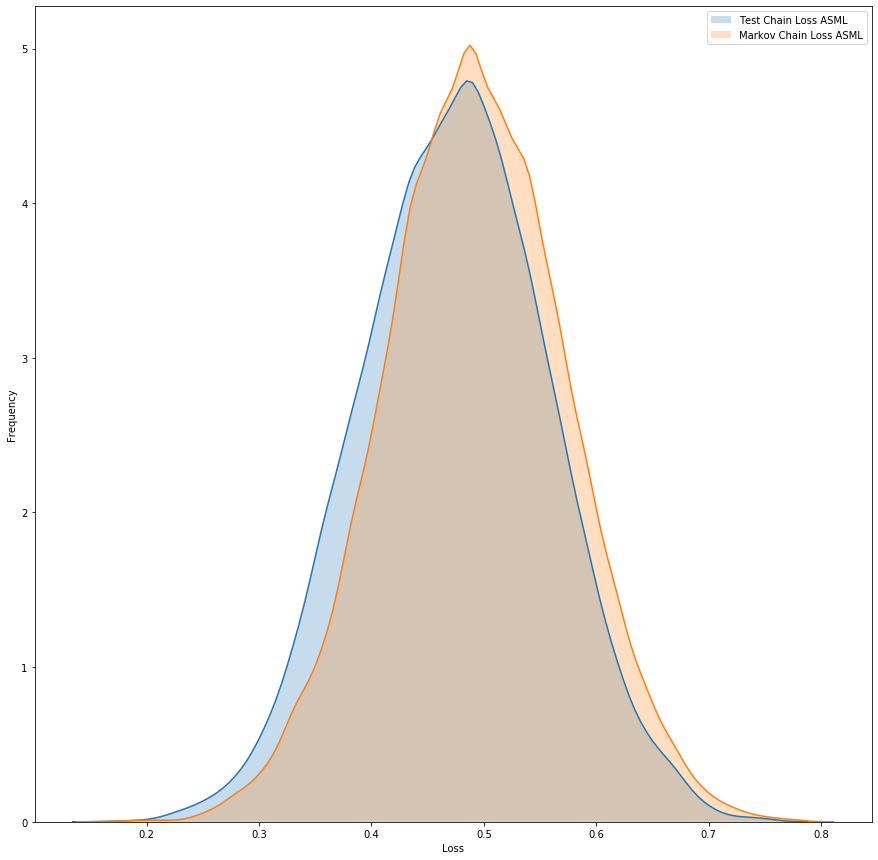

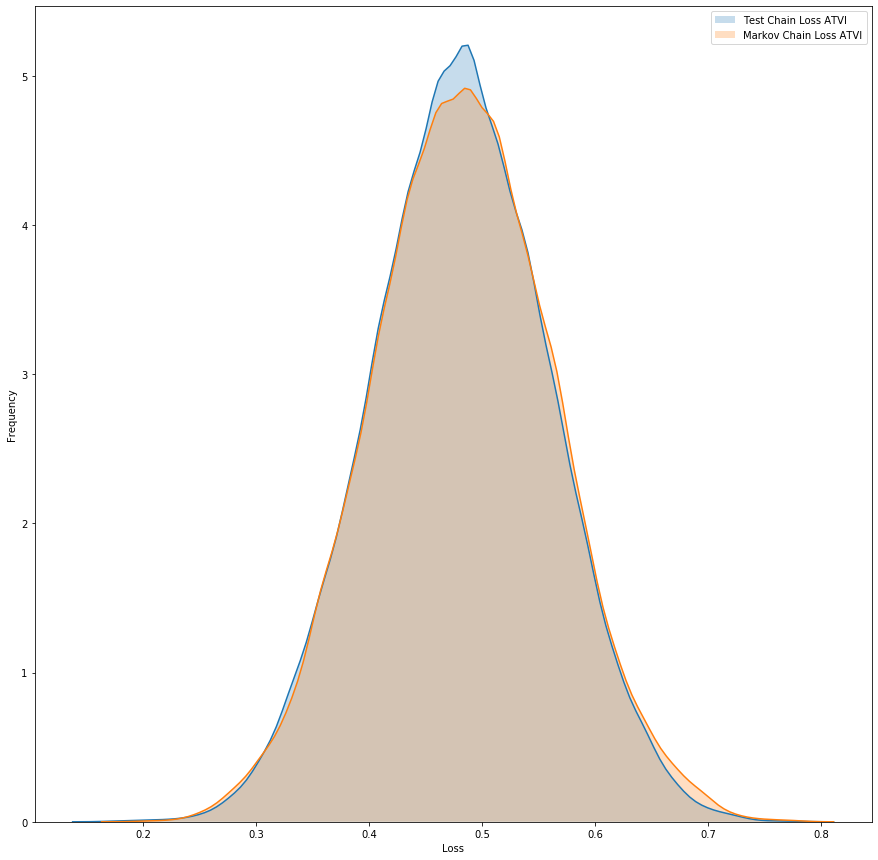

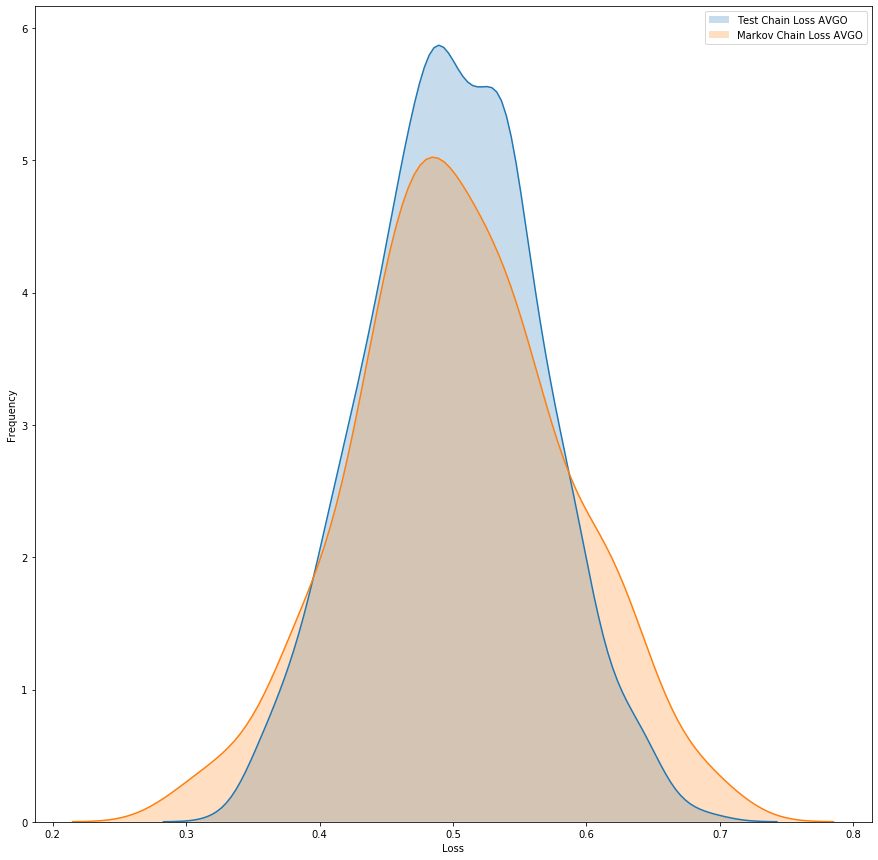

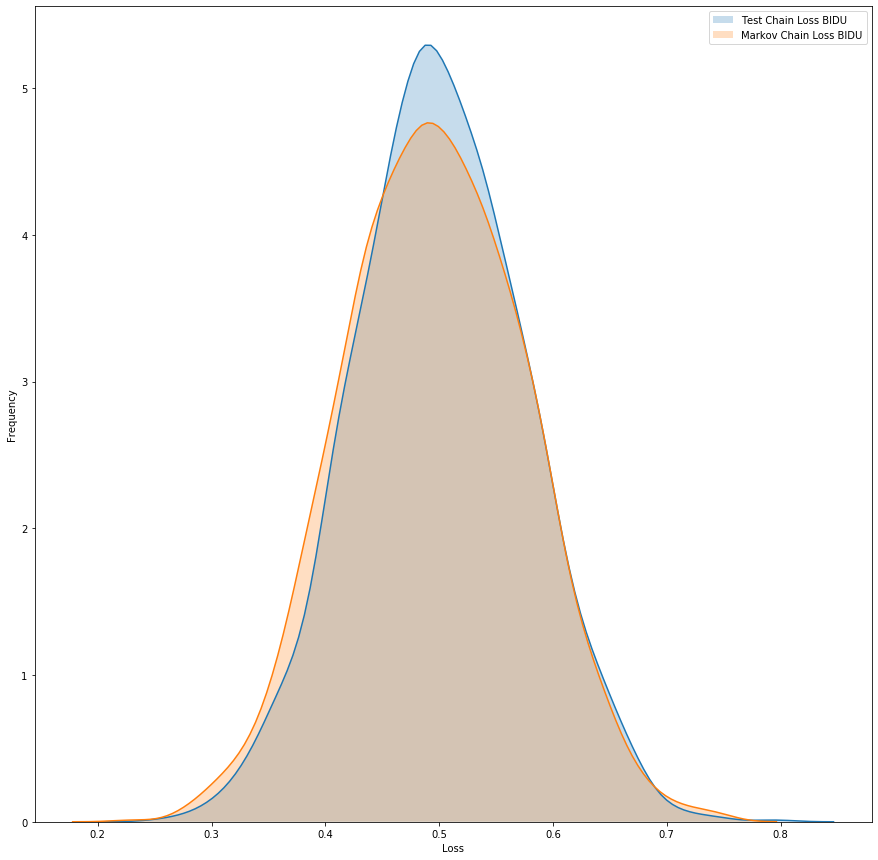

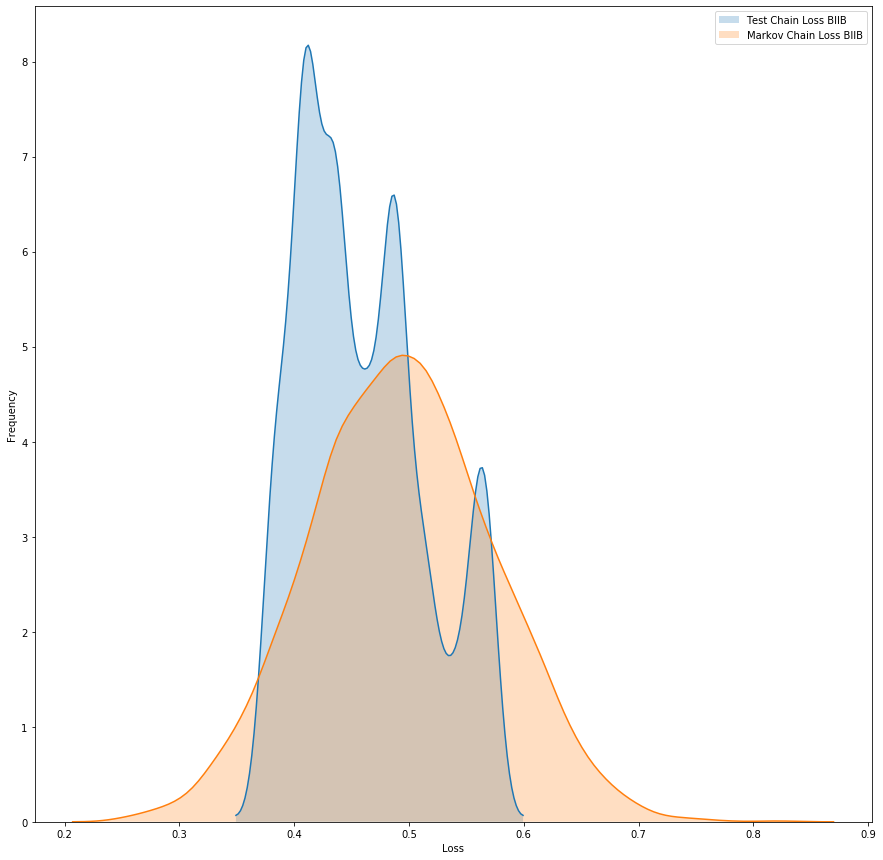

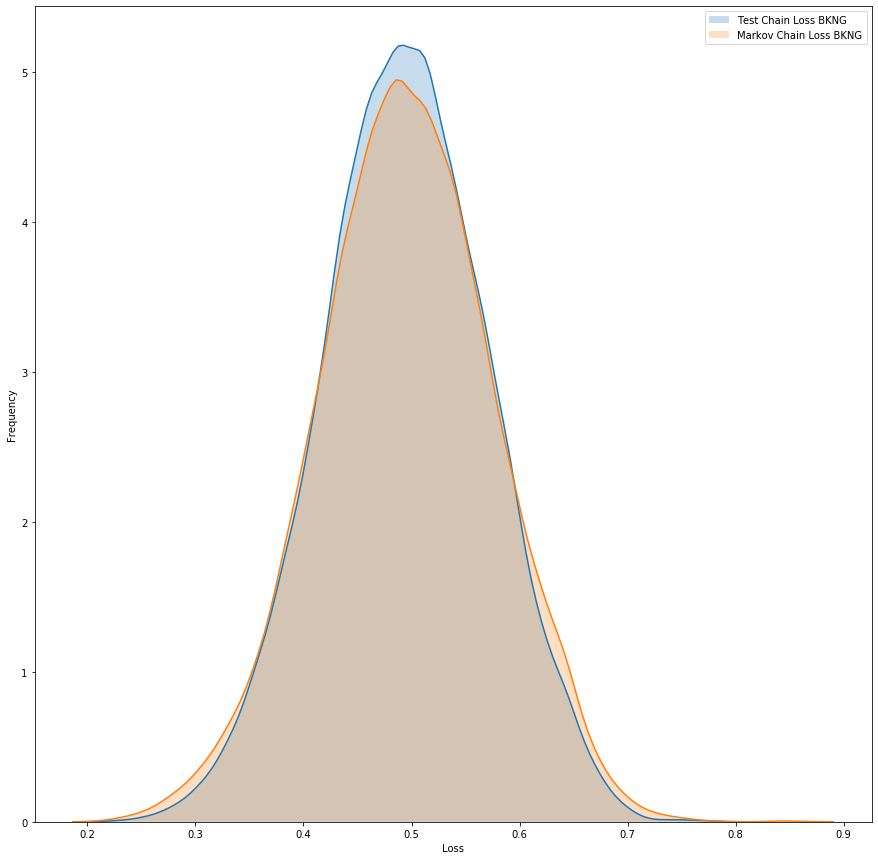

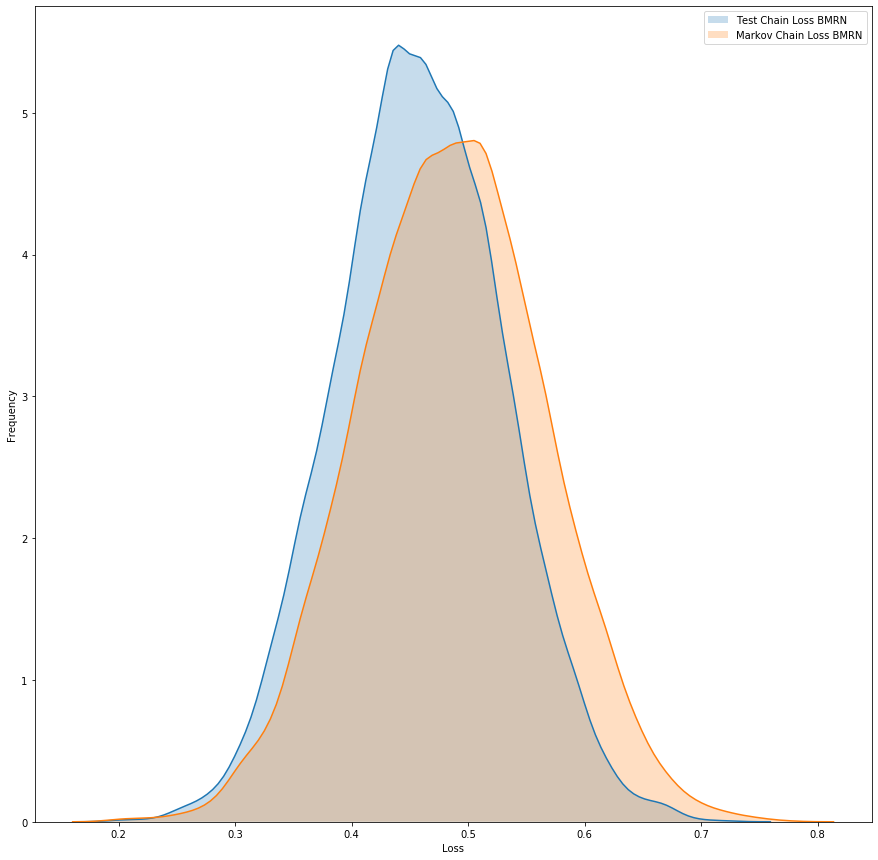

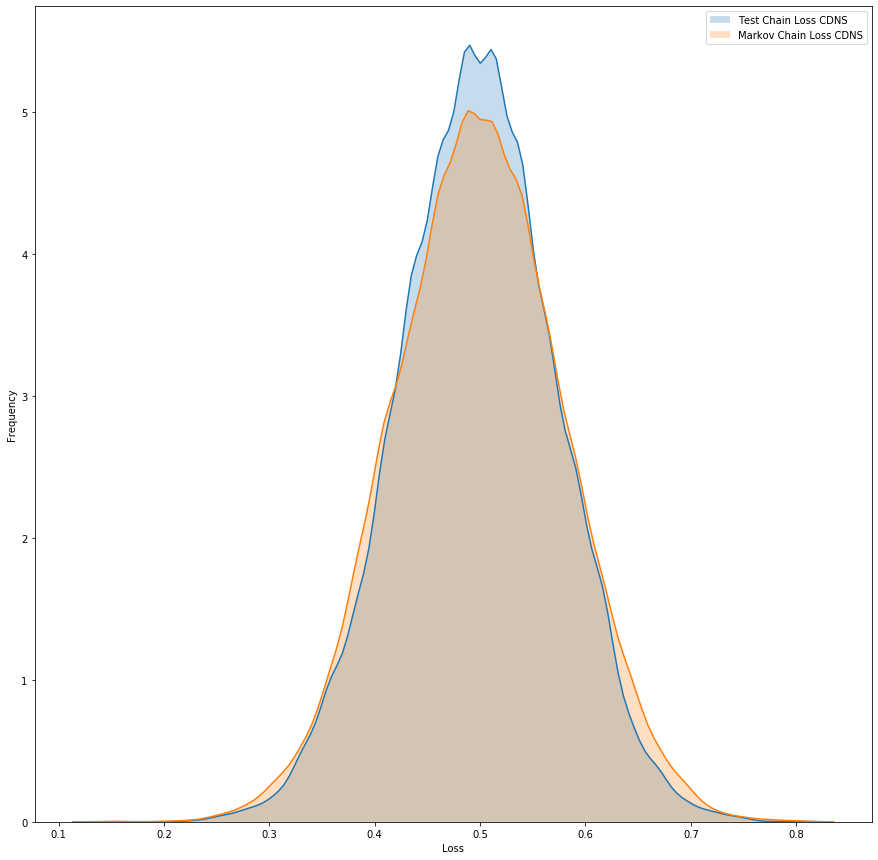

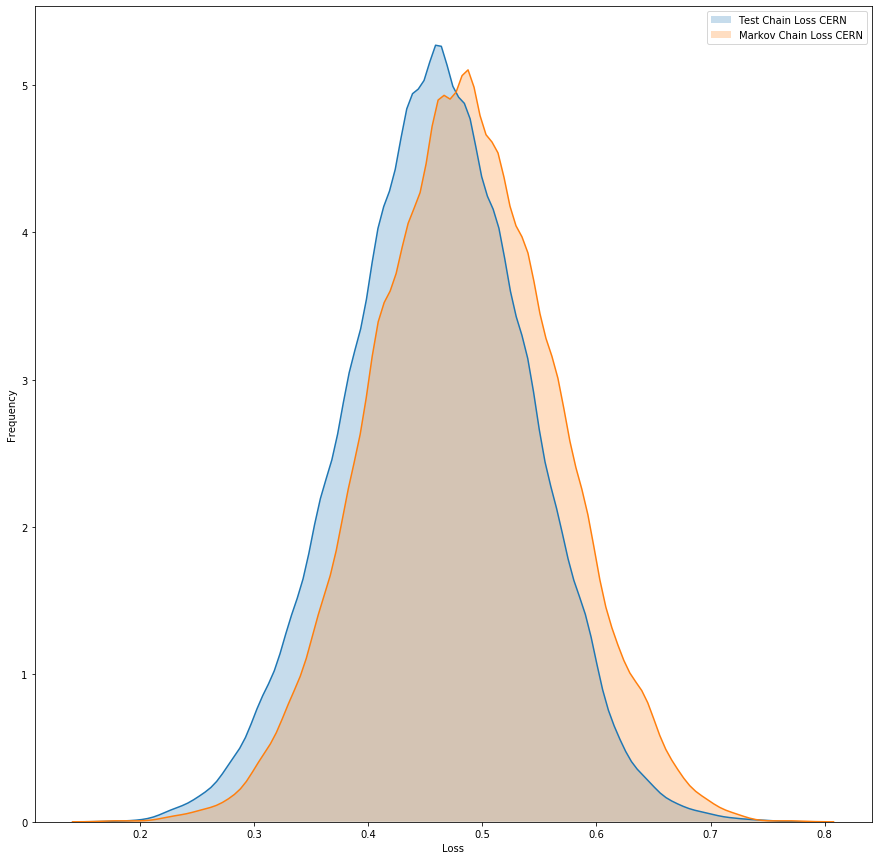

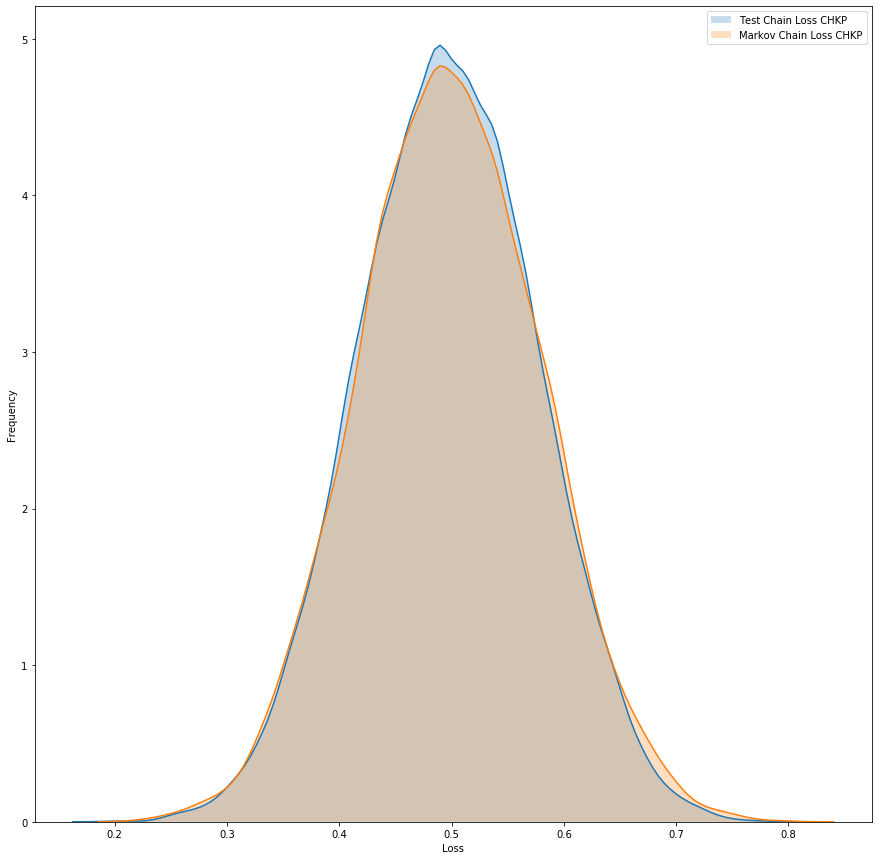

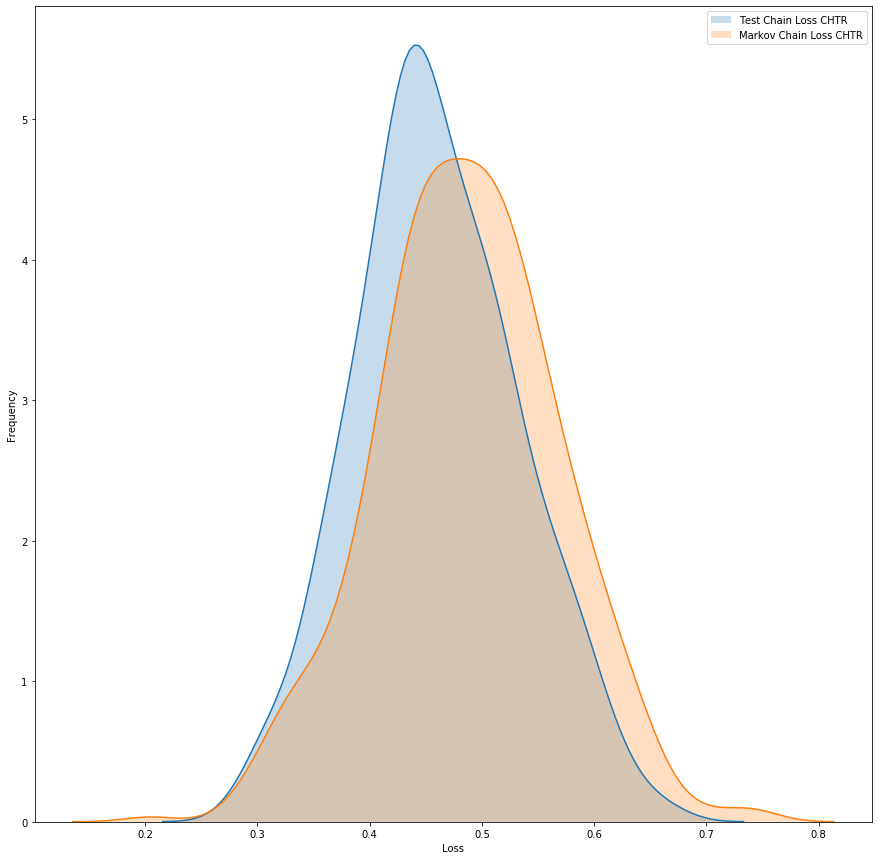

27.38095238095238% done!


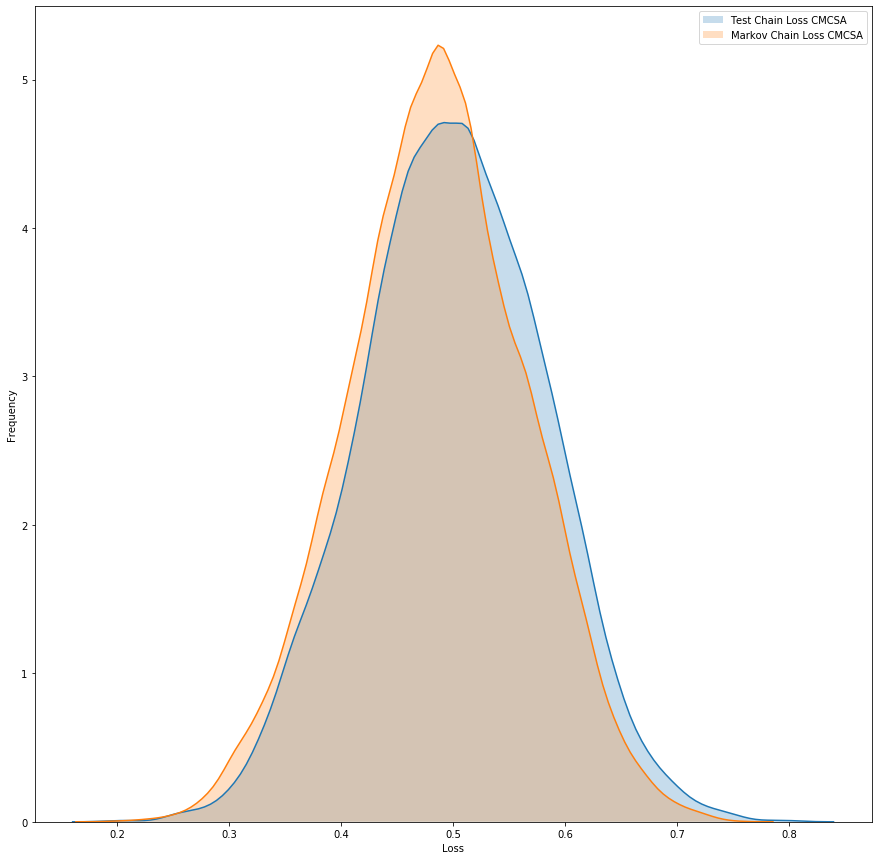

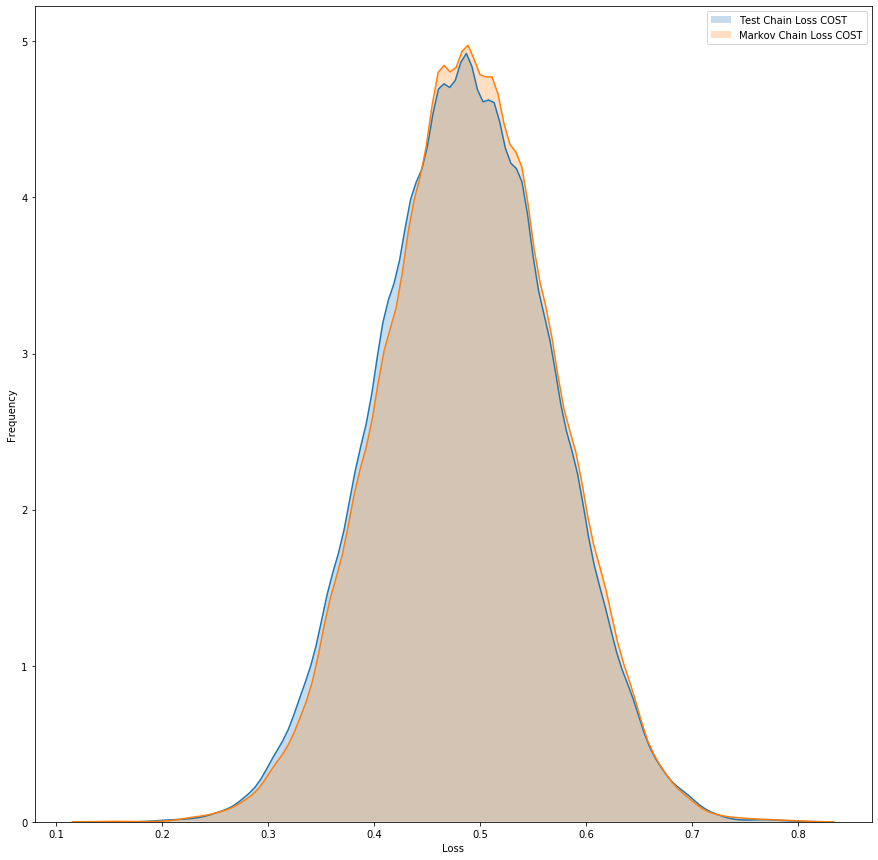

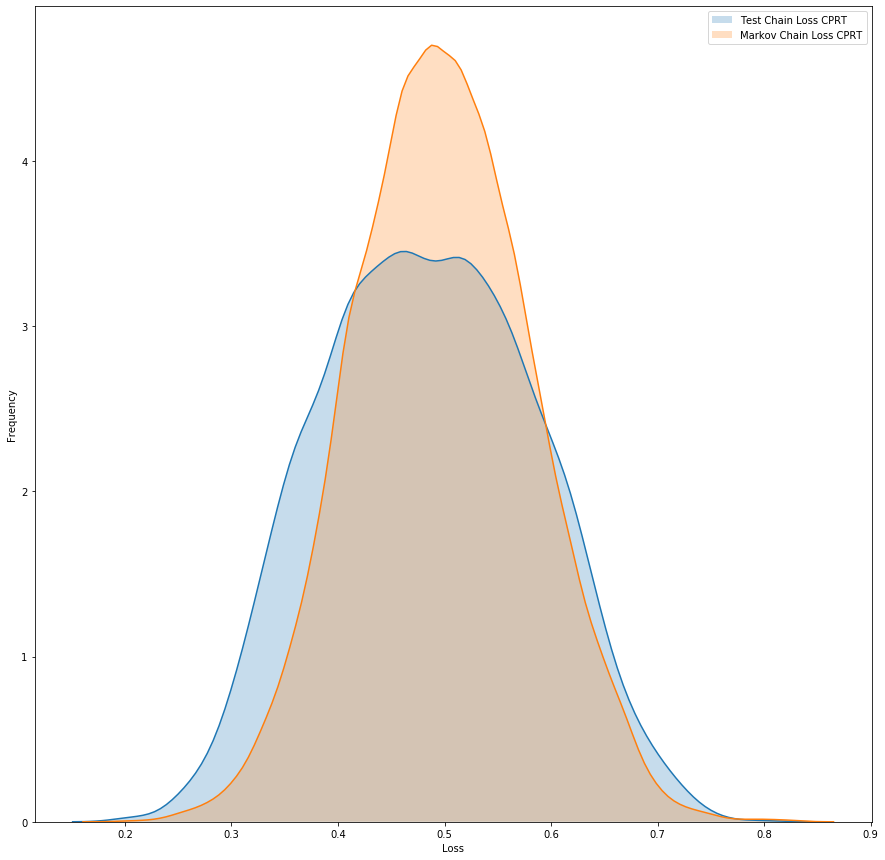

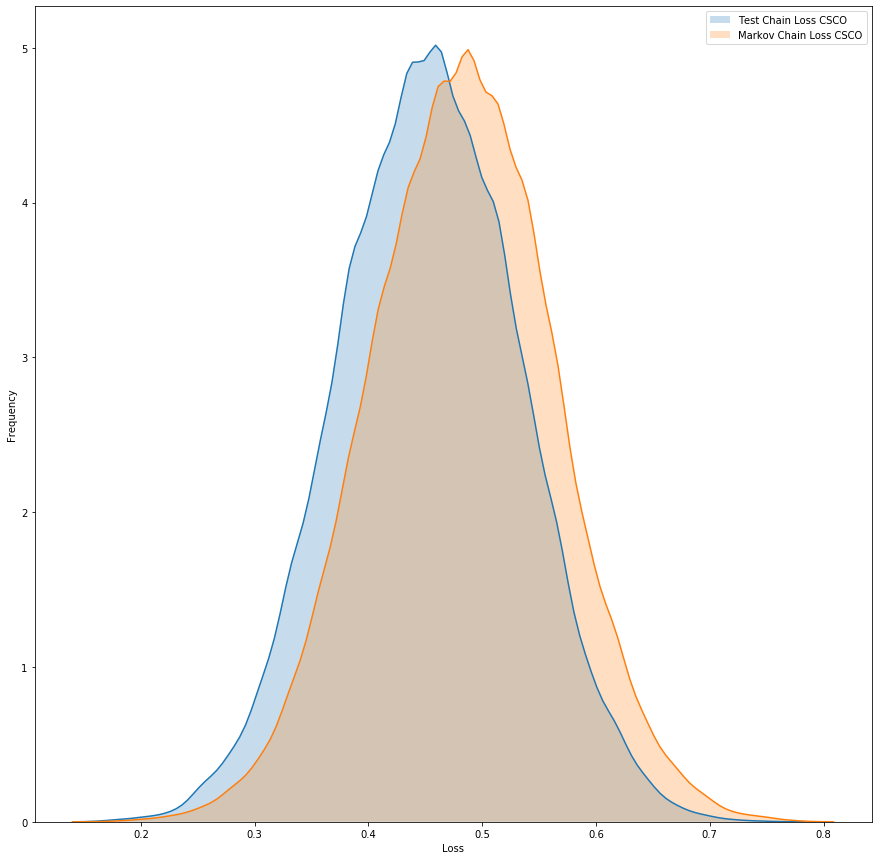

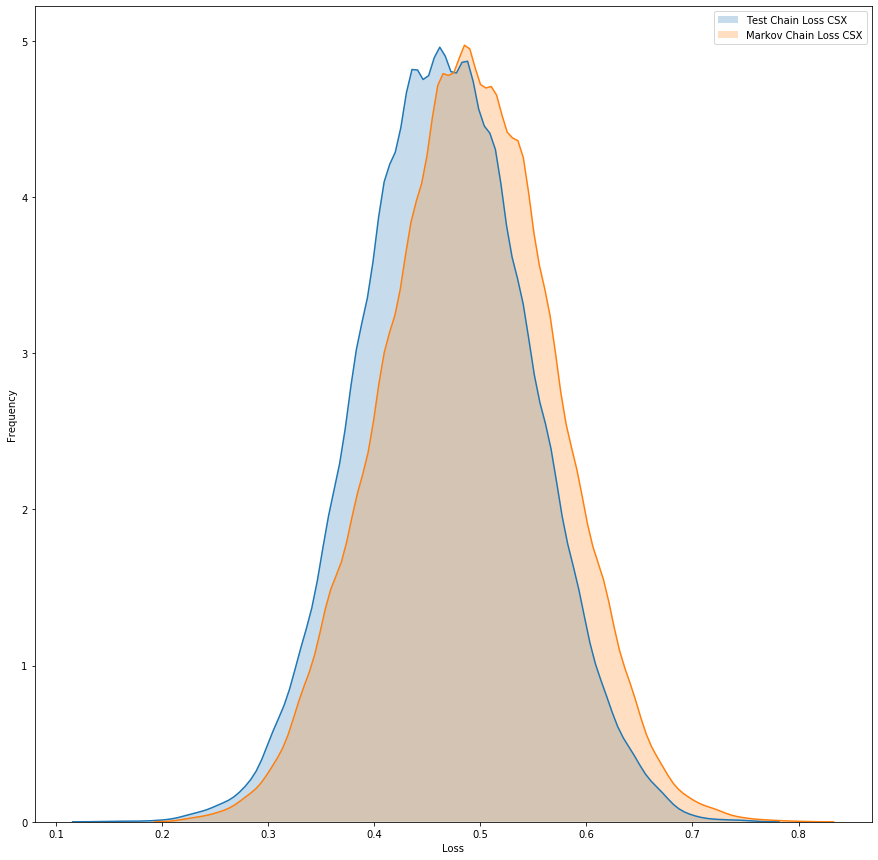

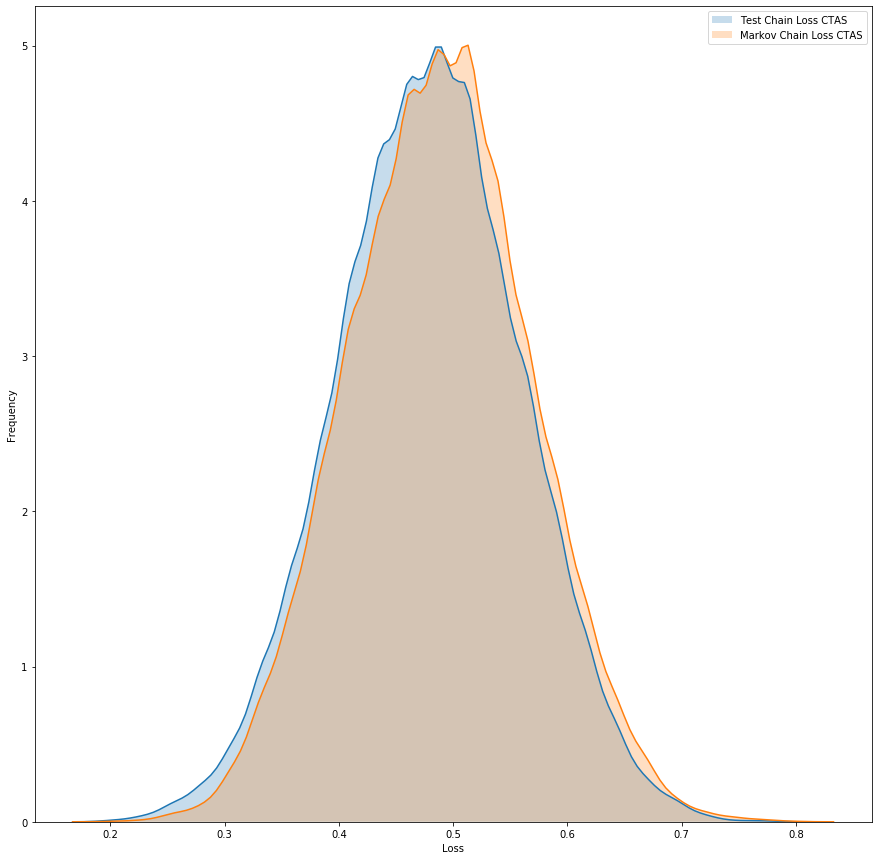

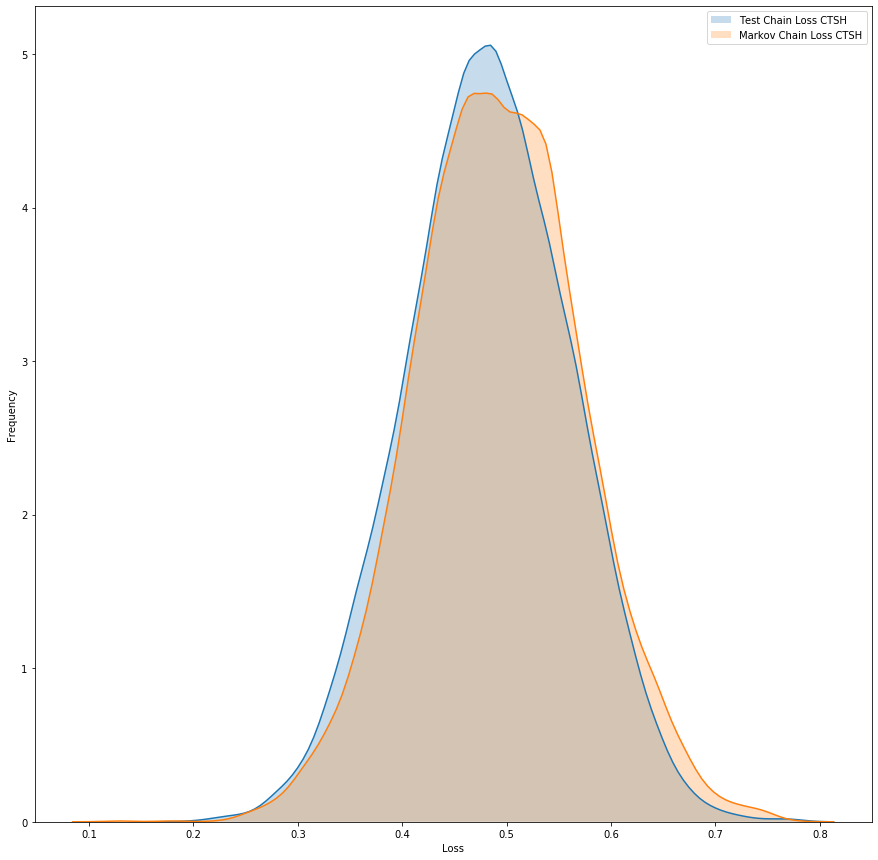

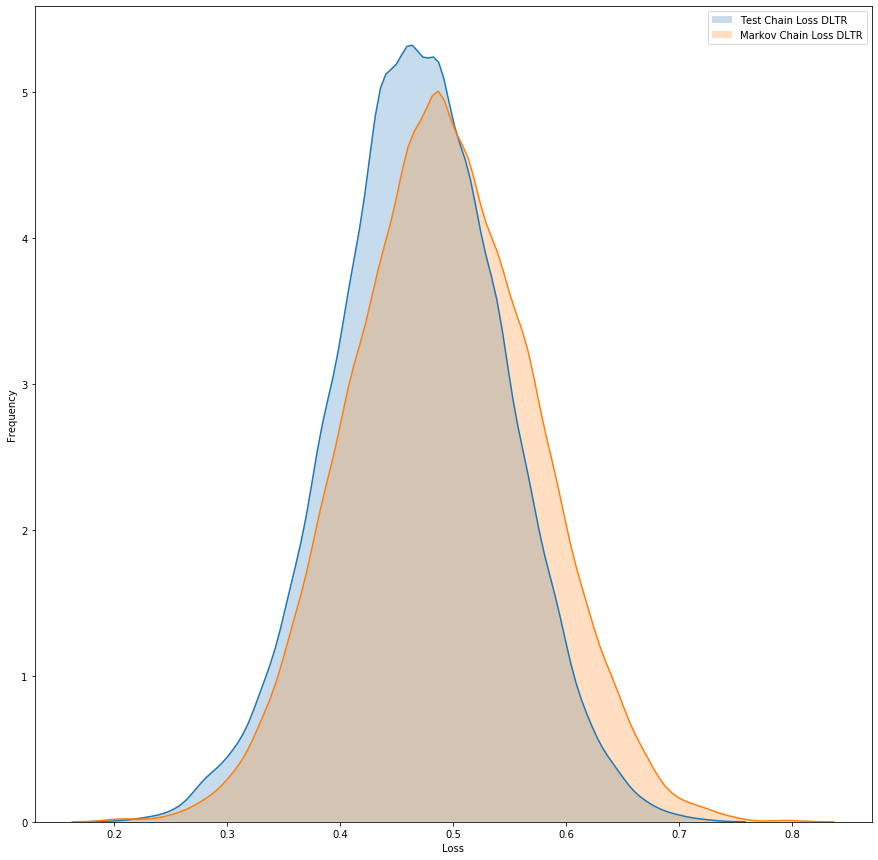

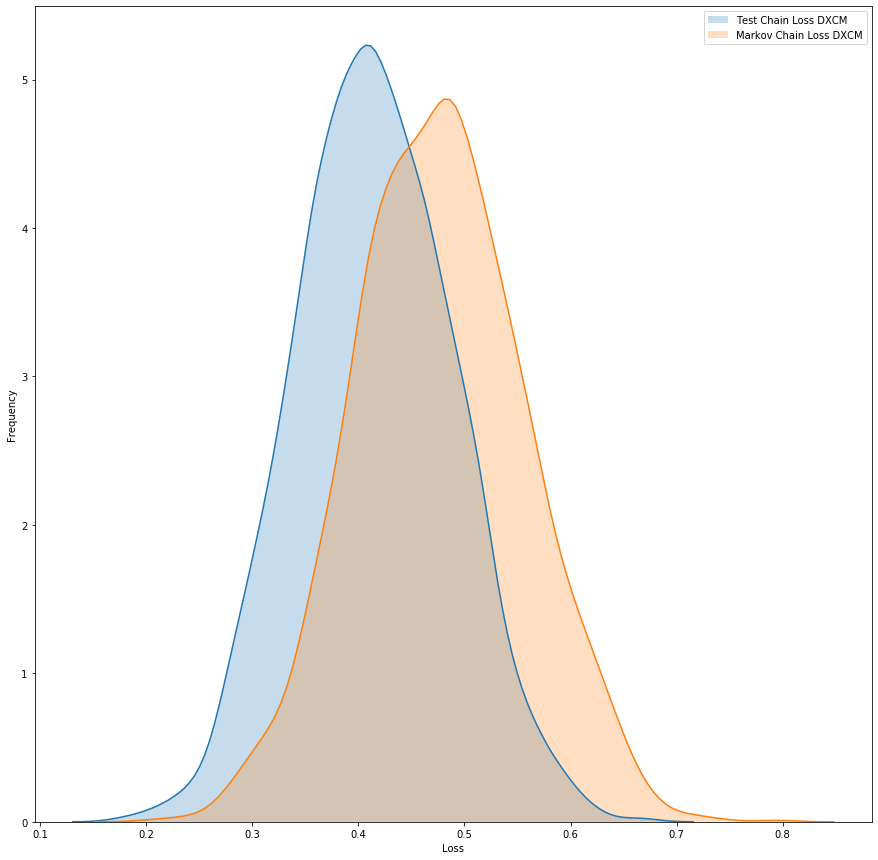

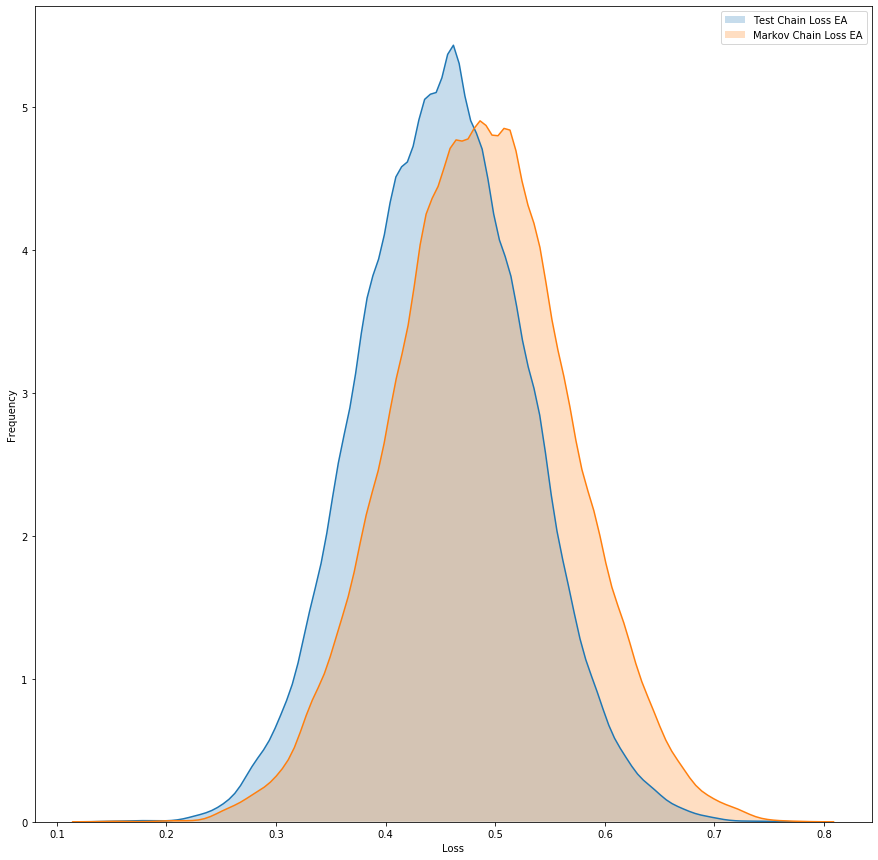

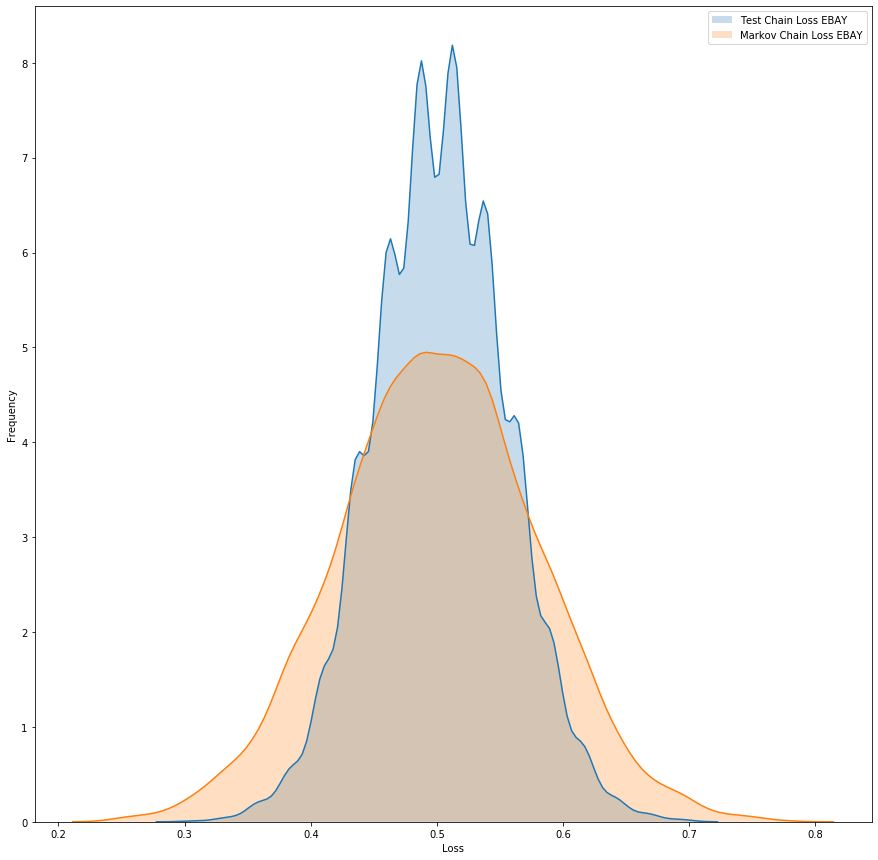

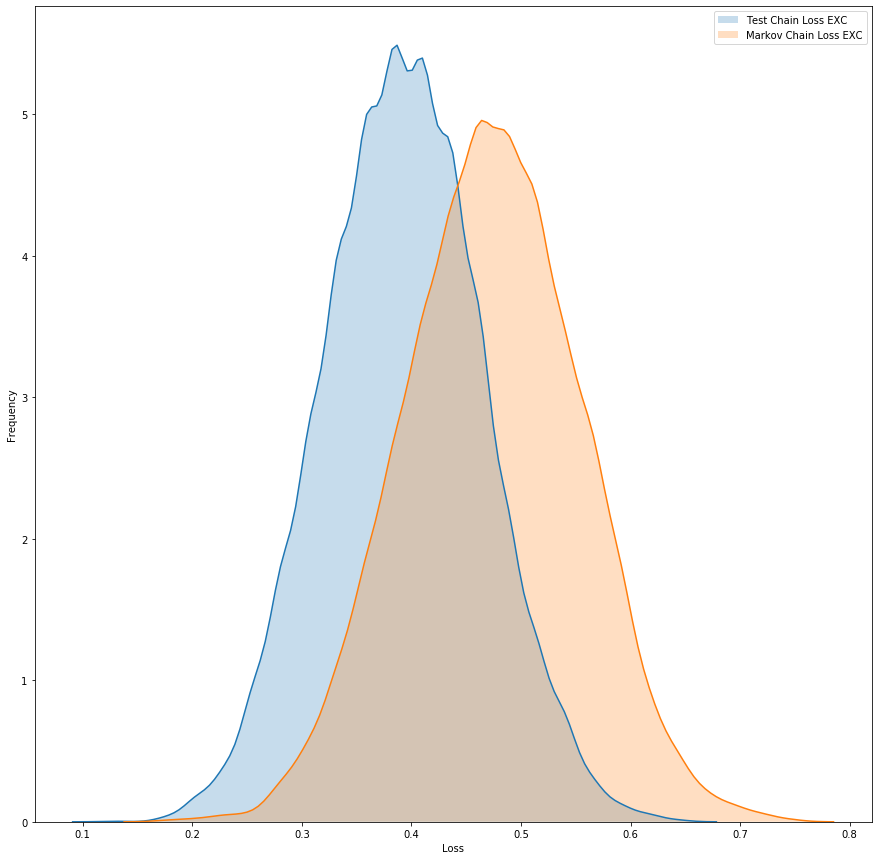

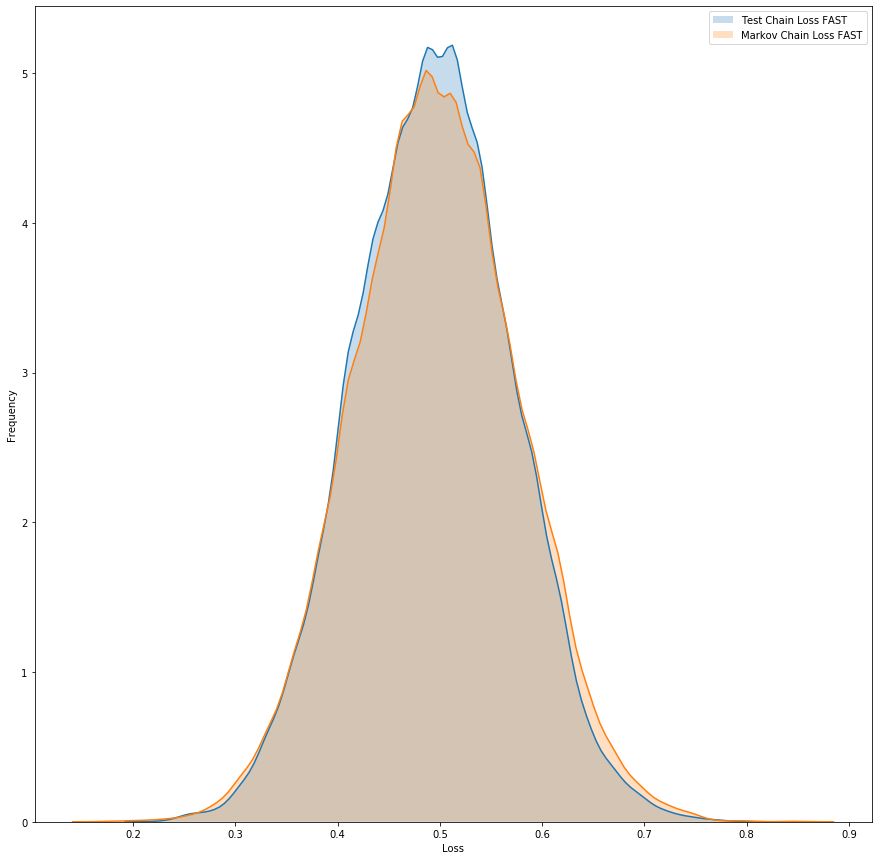

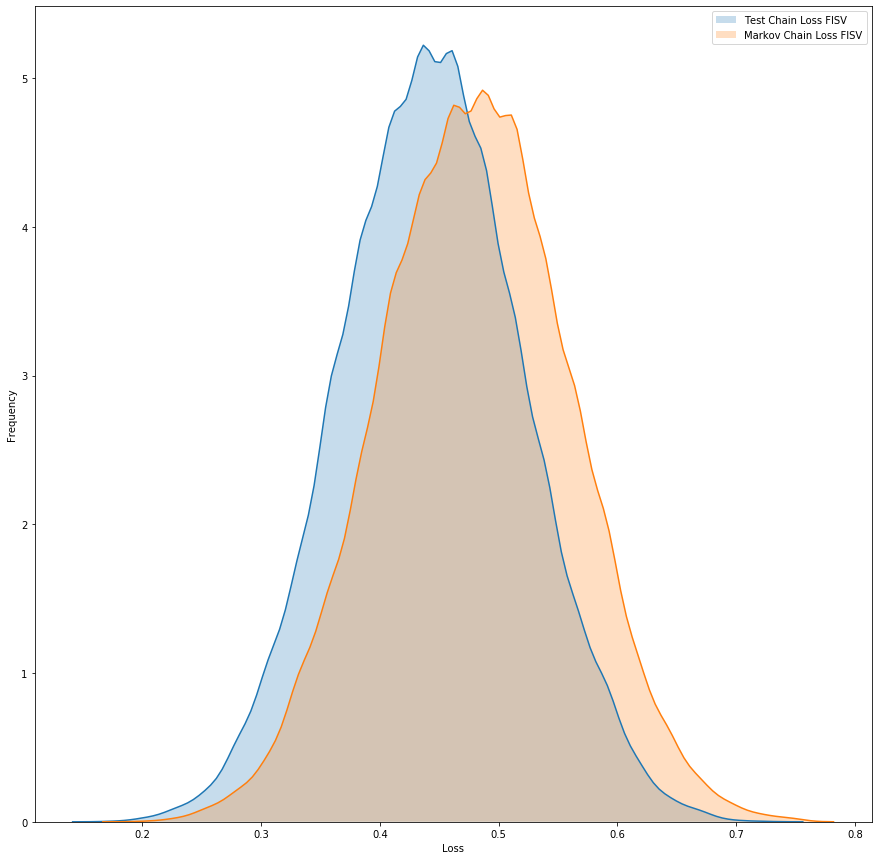

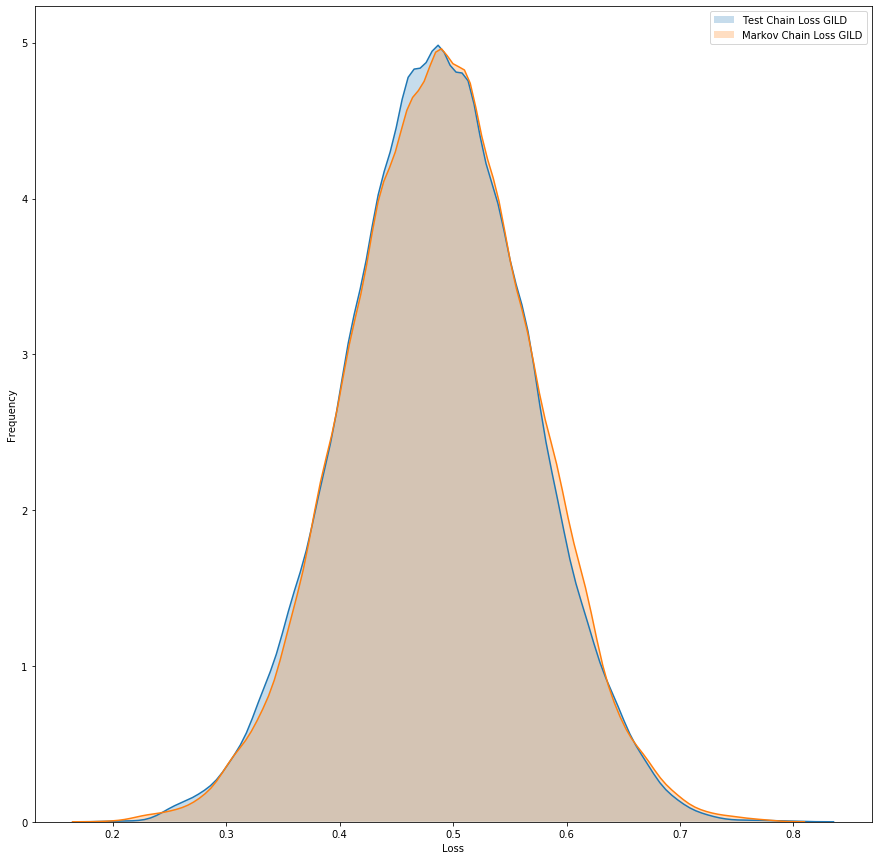

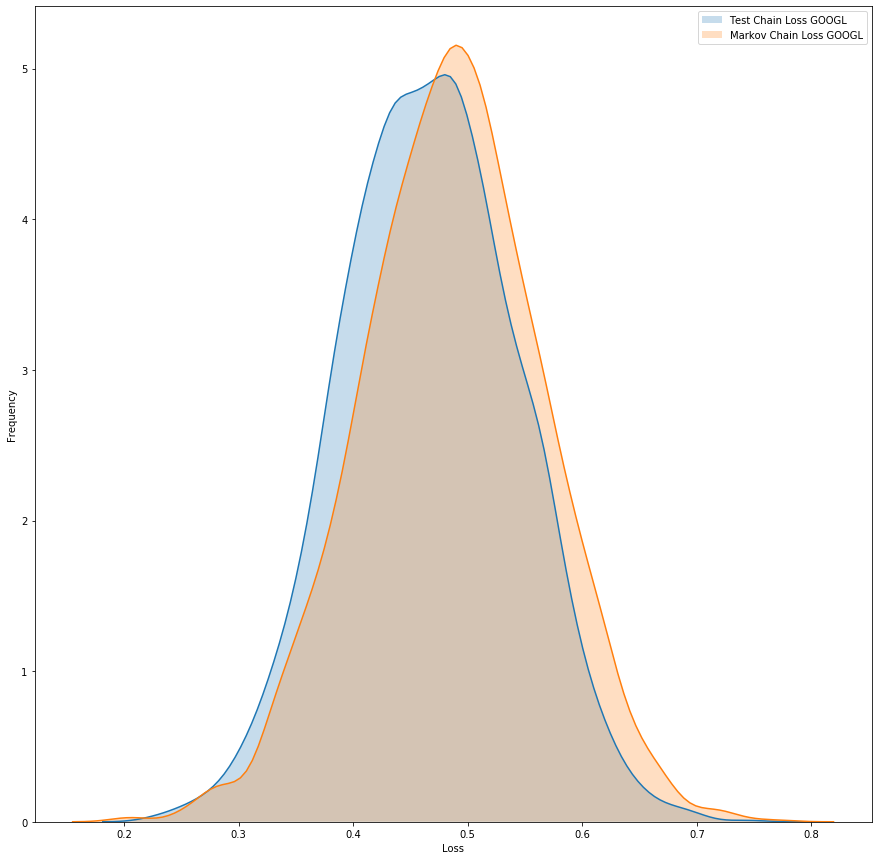

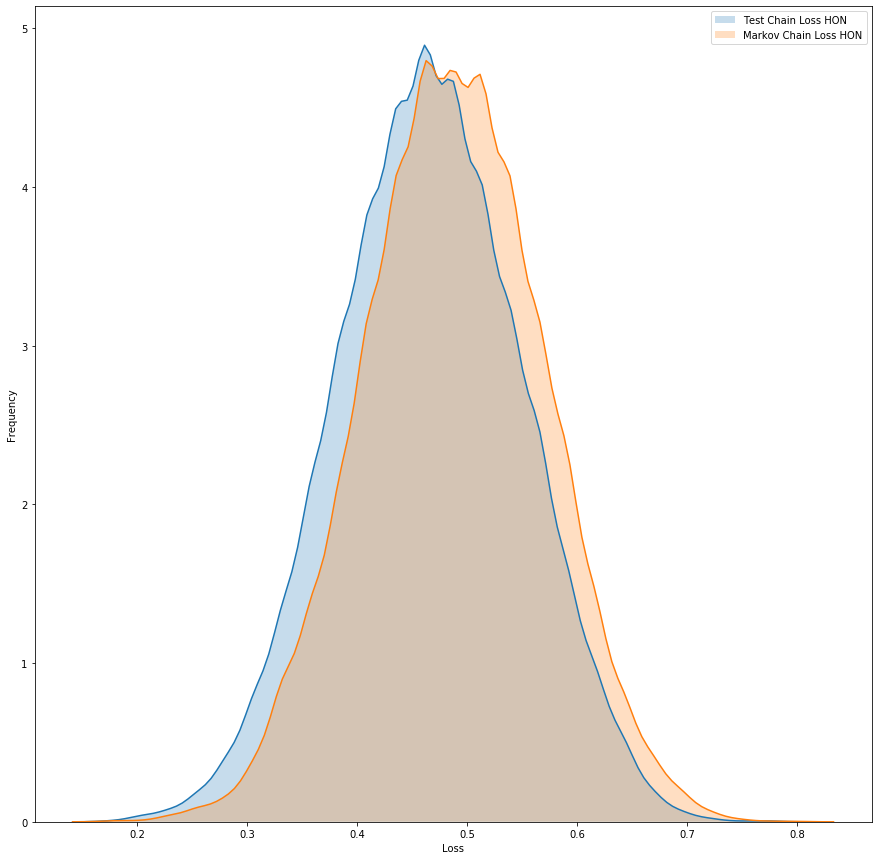

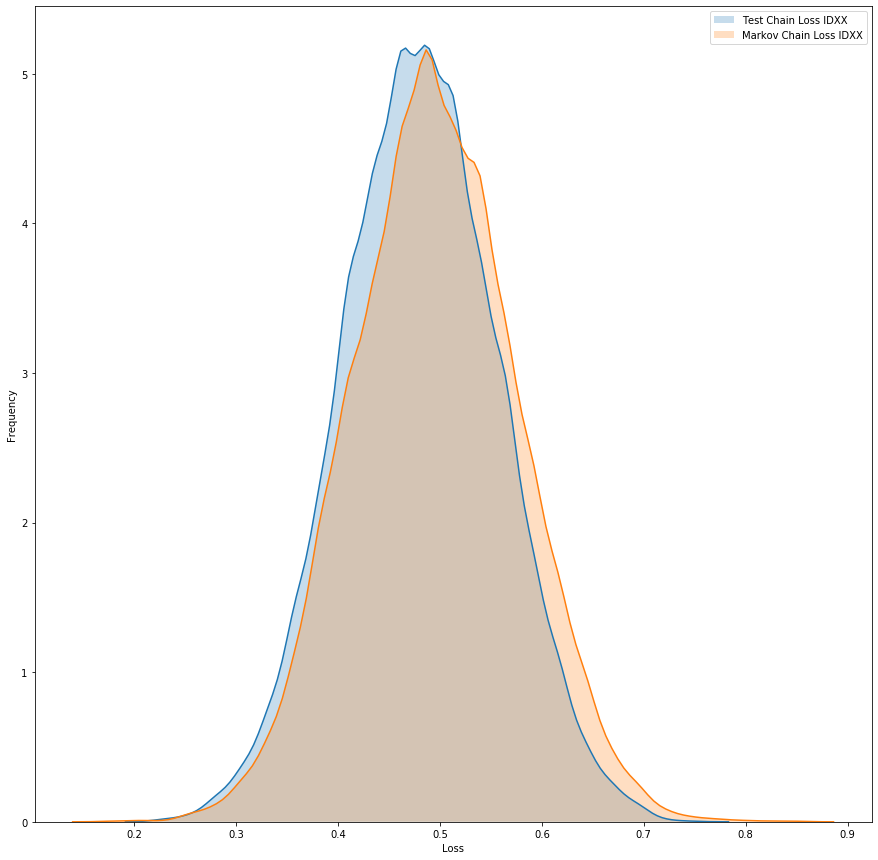

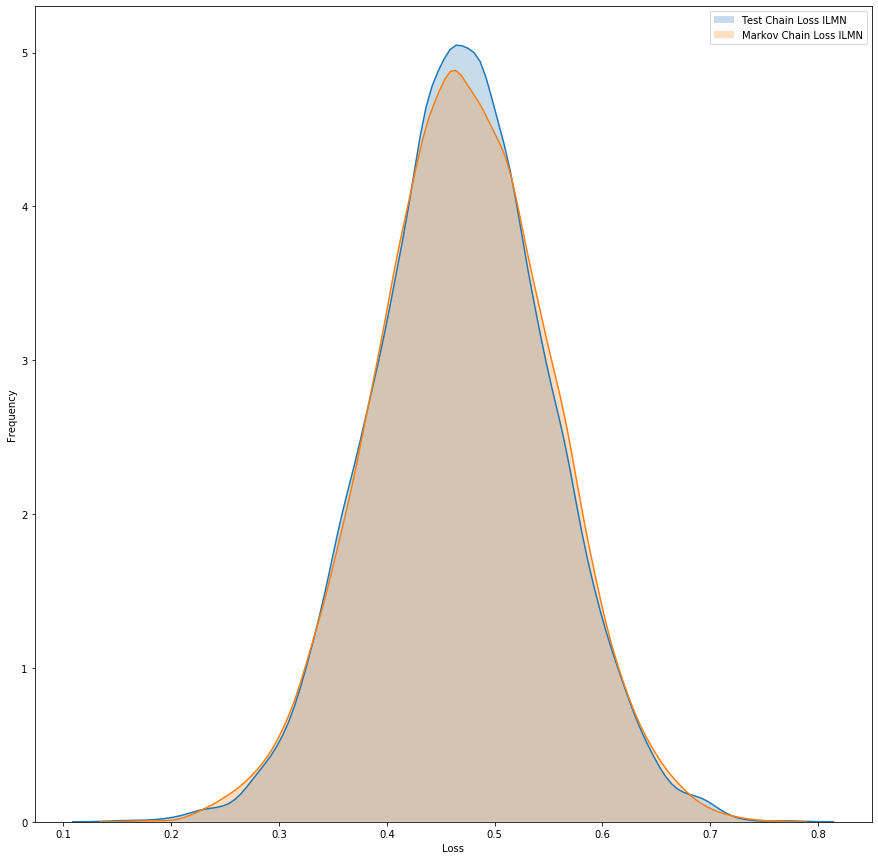

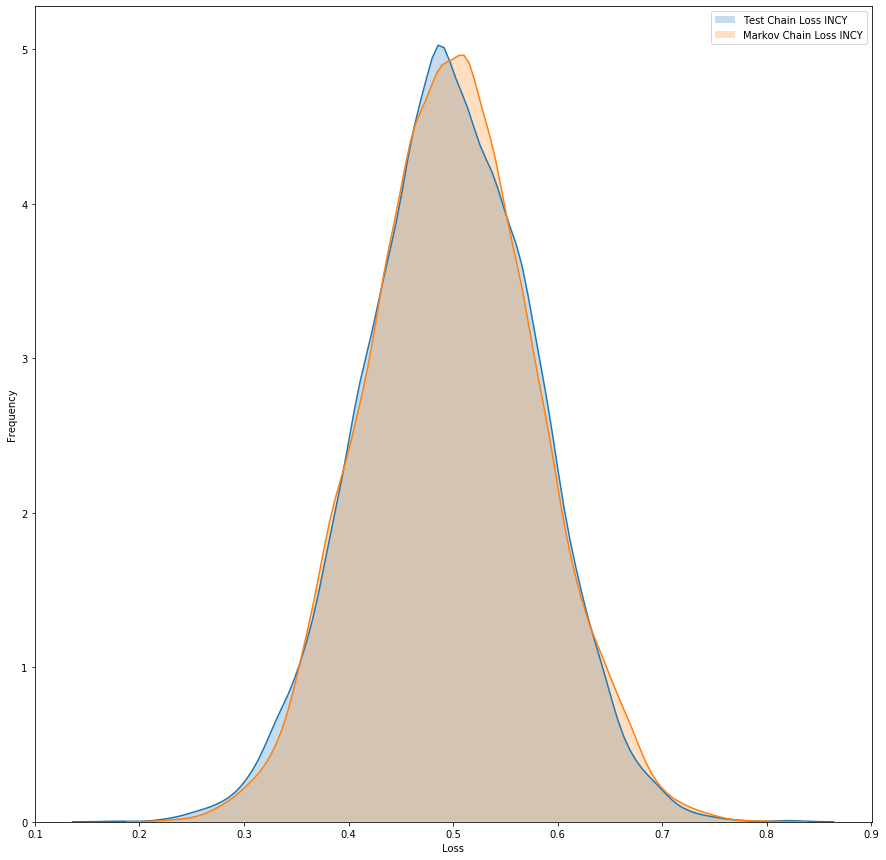

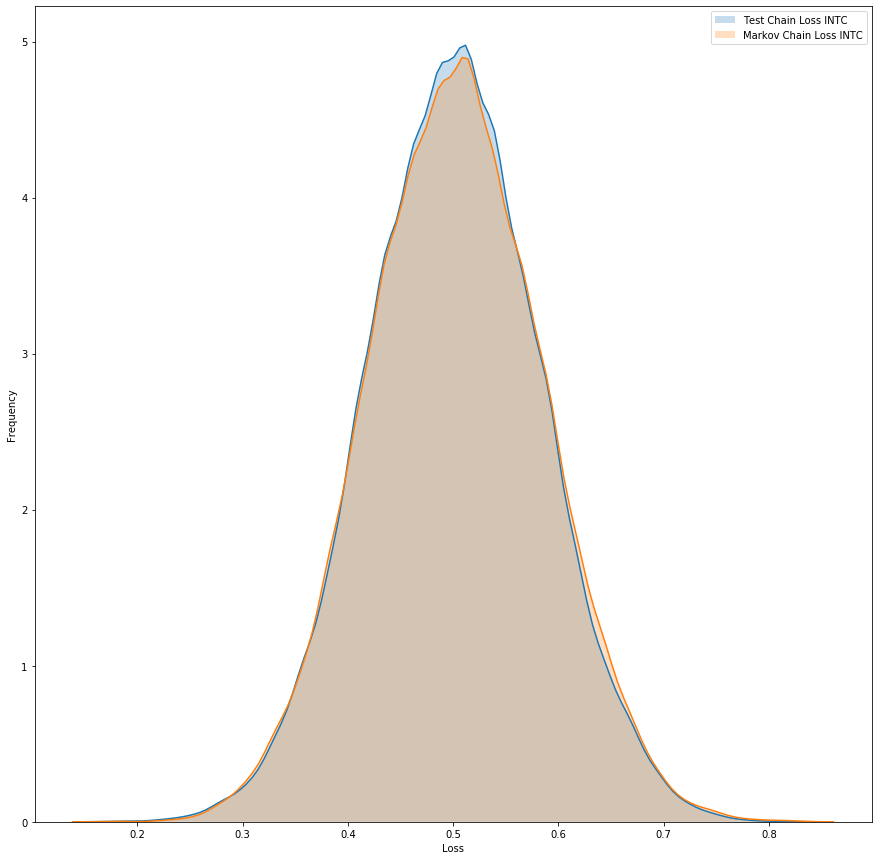

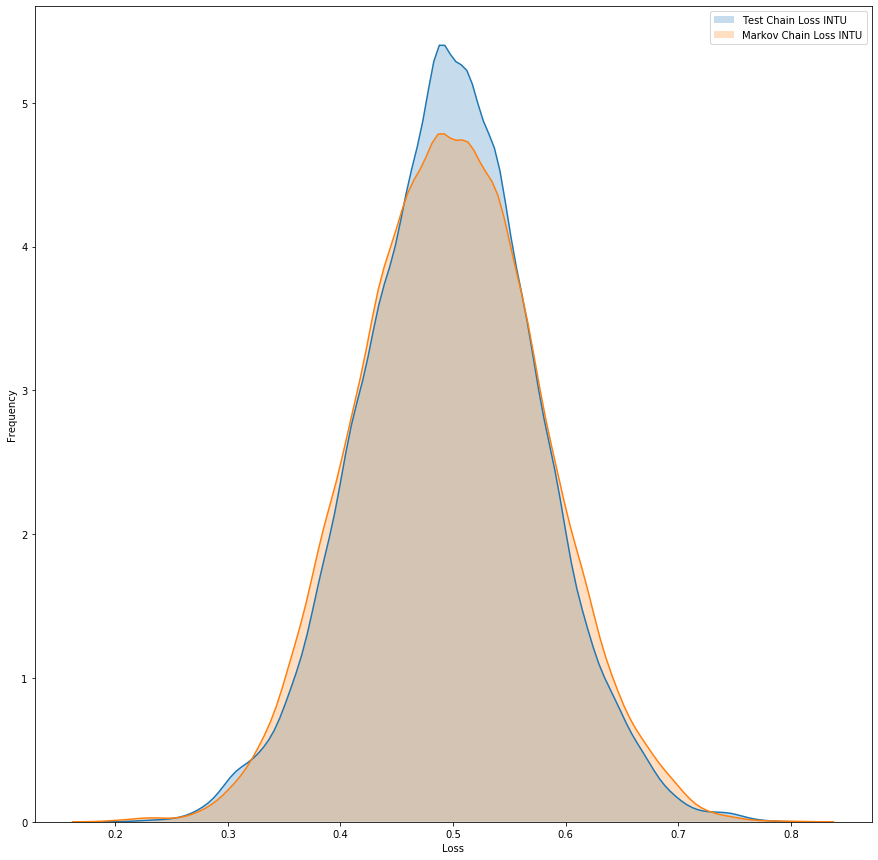

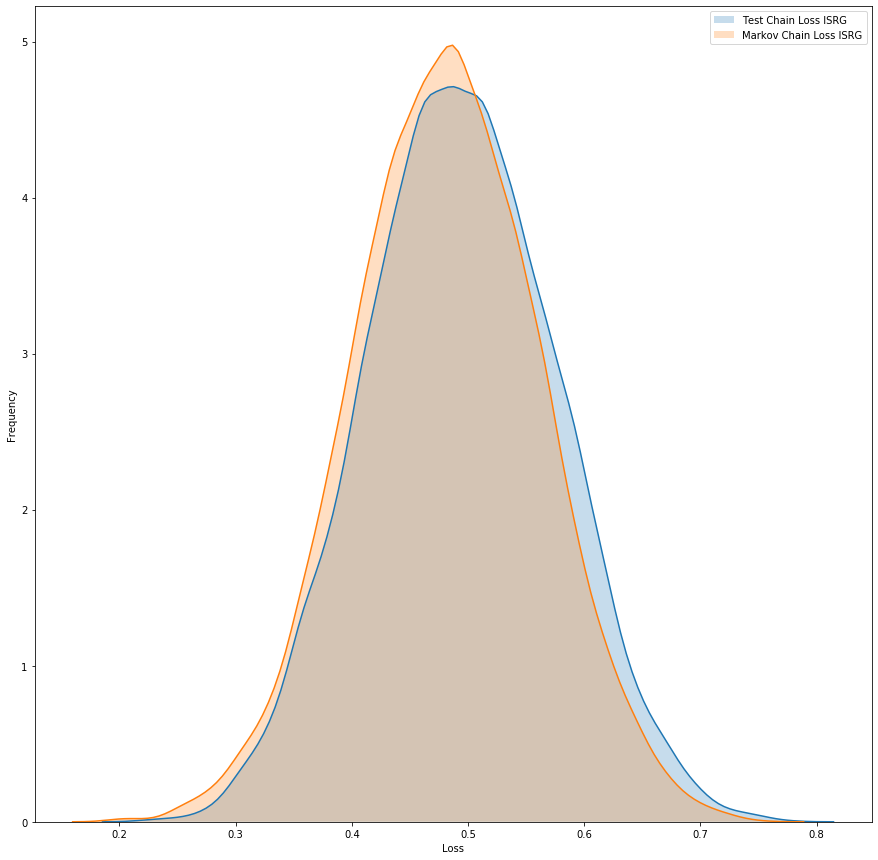

54.76190476190476% done!


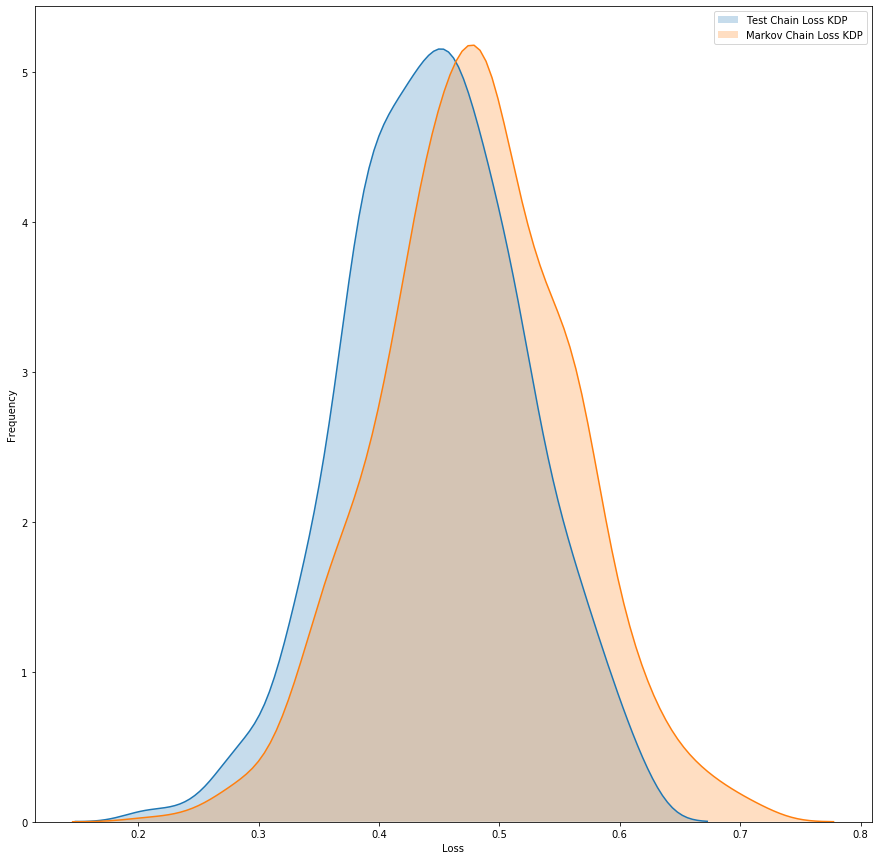

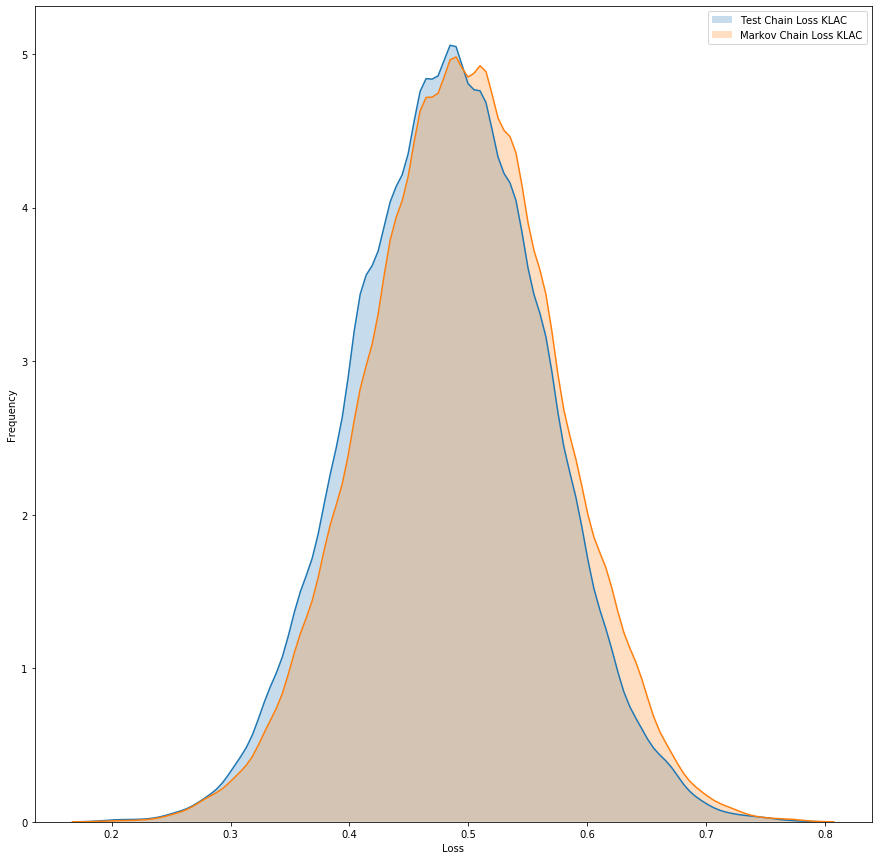

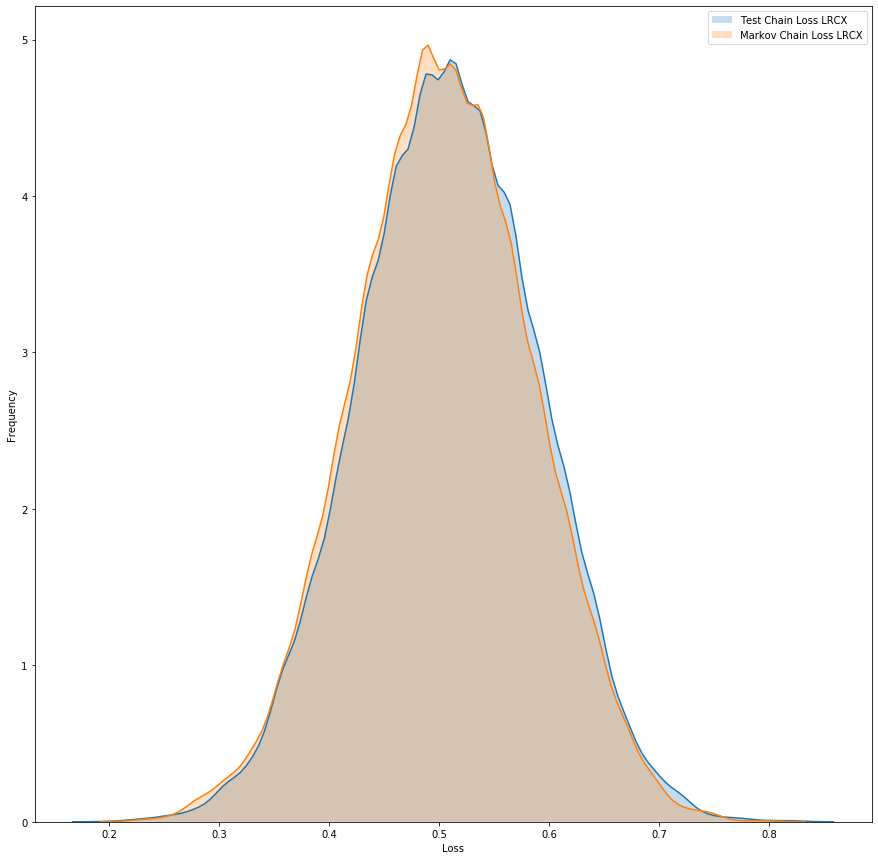

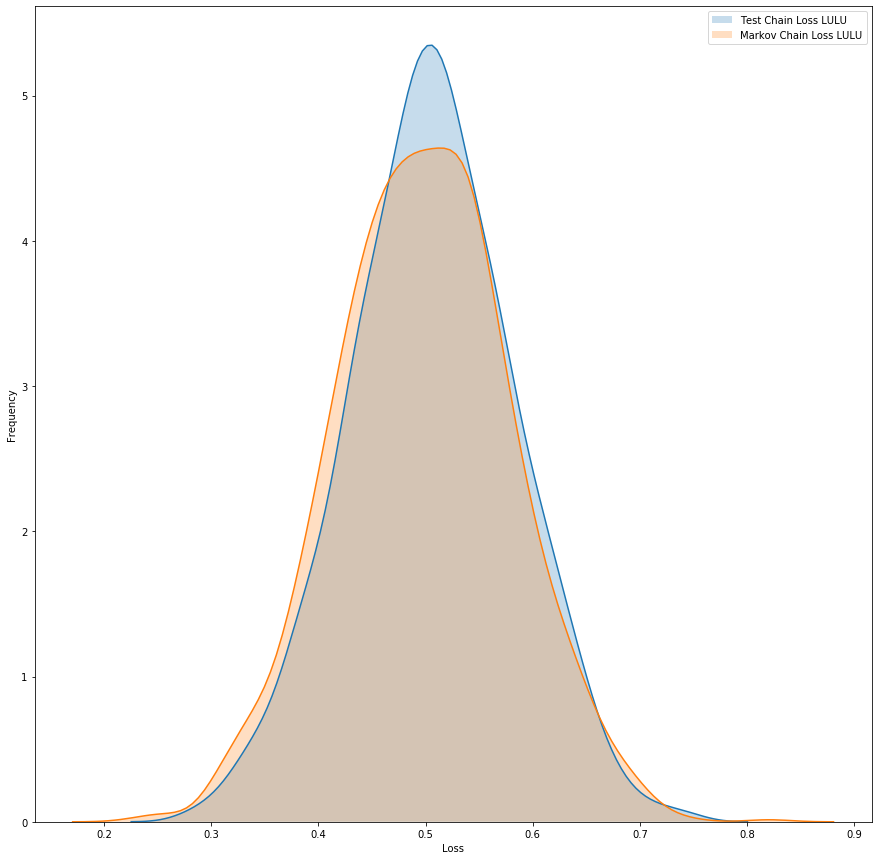

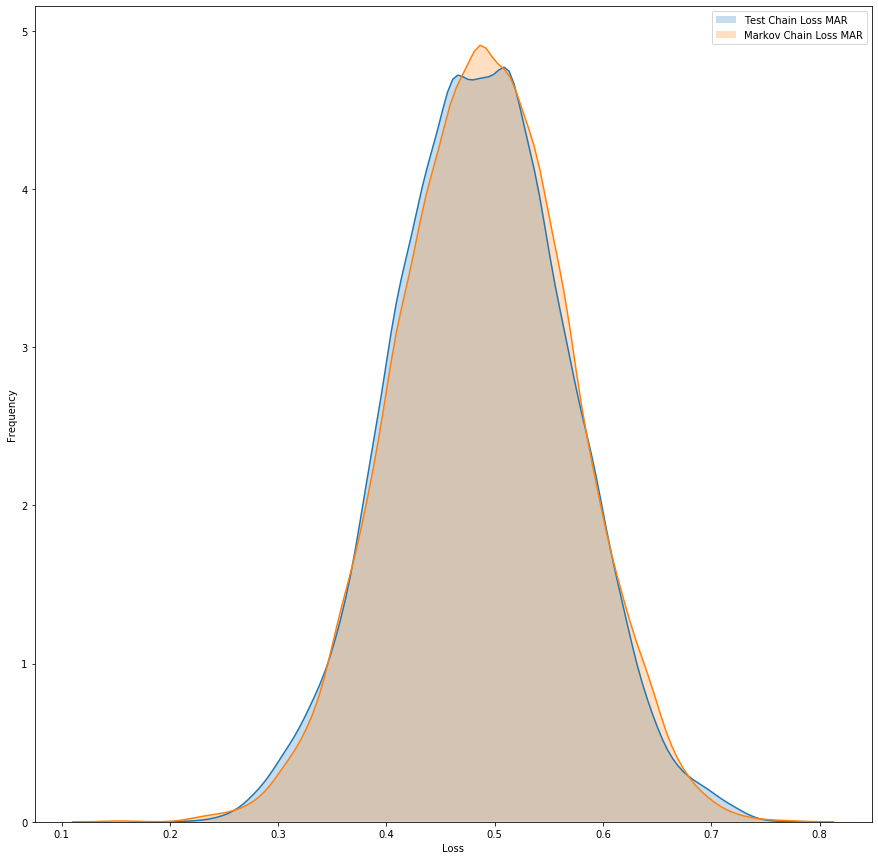

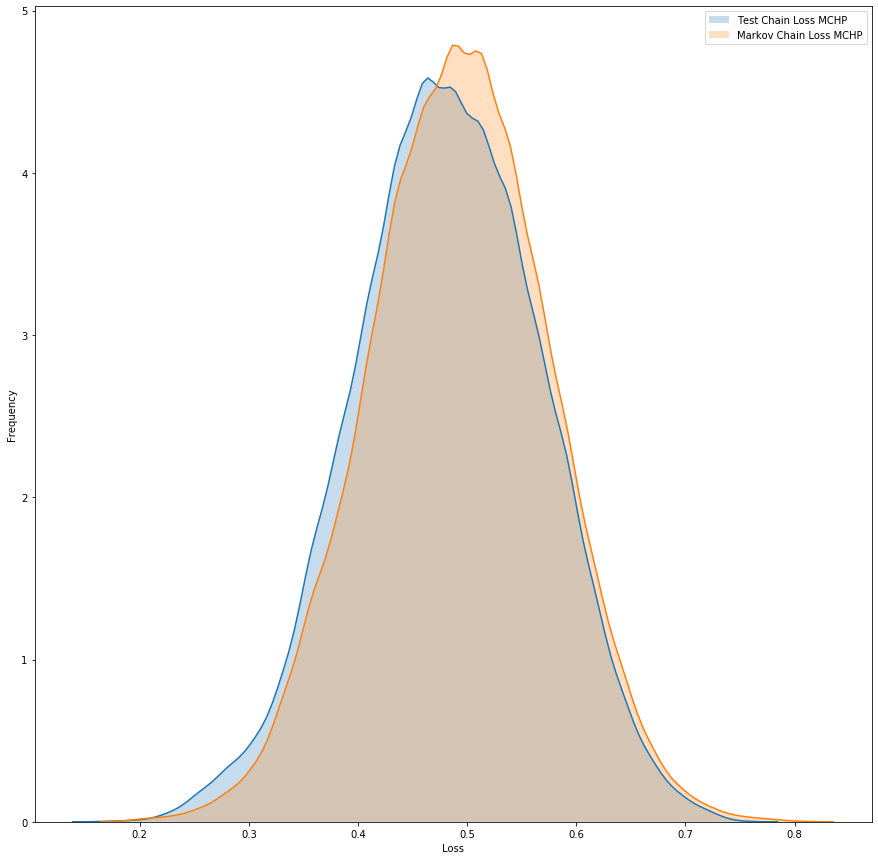

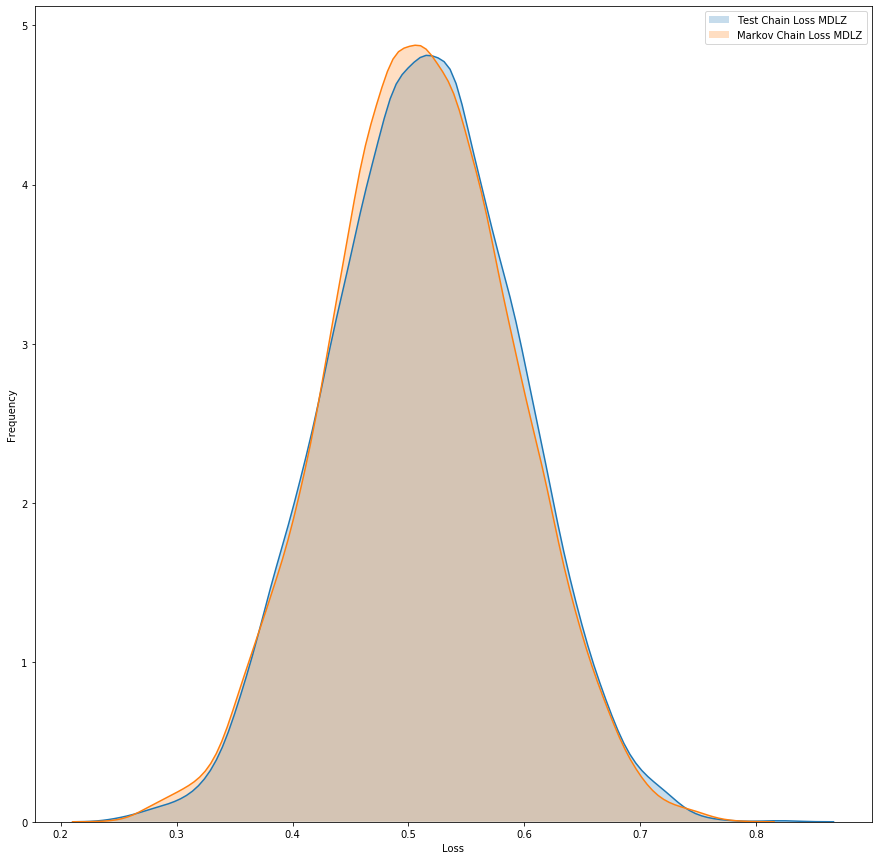

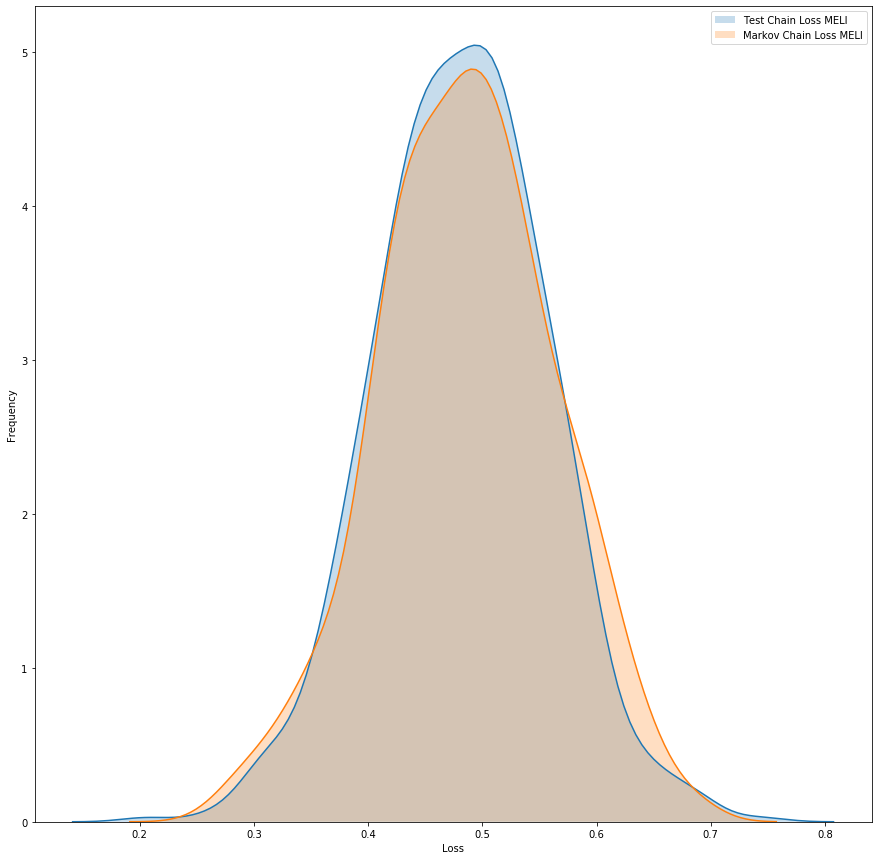

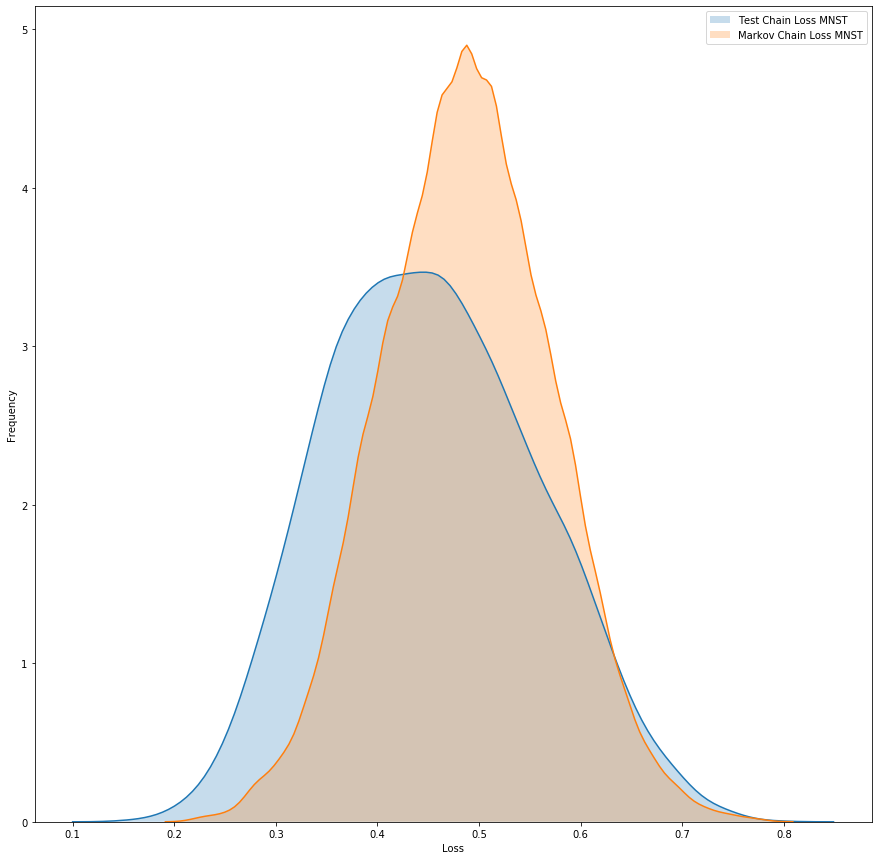

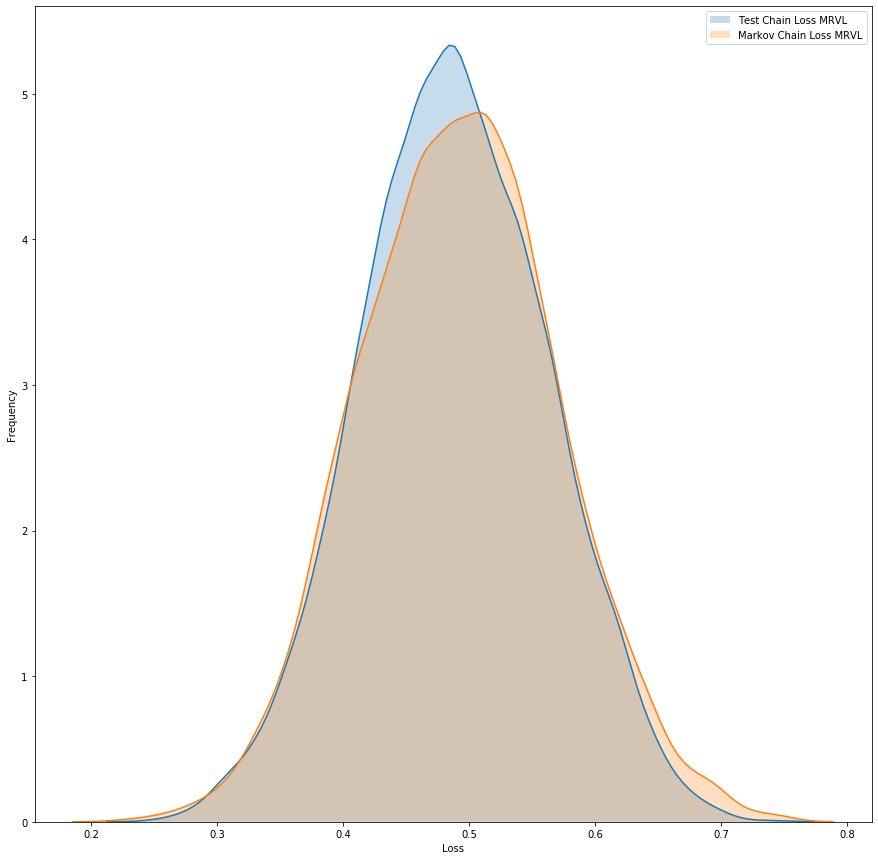

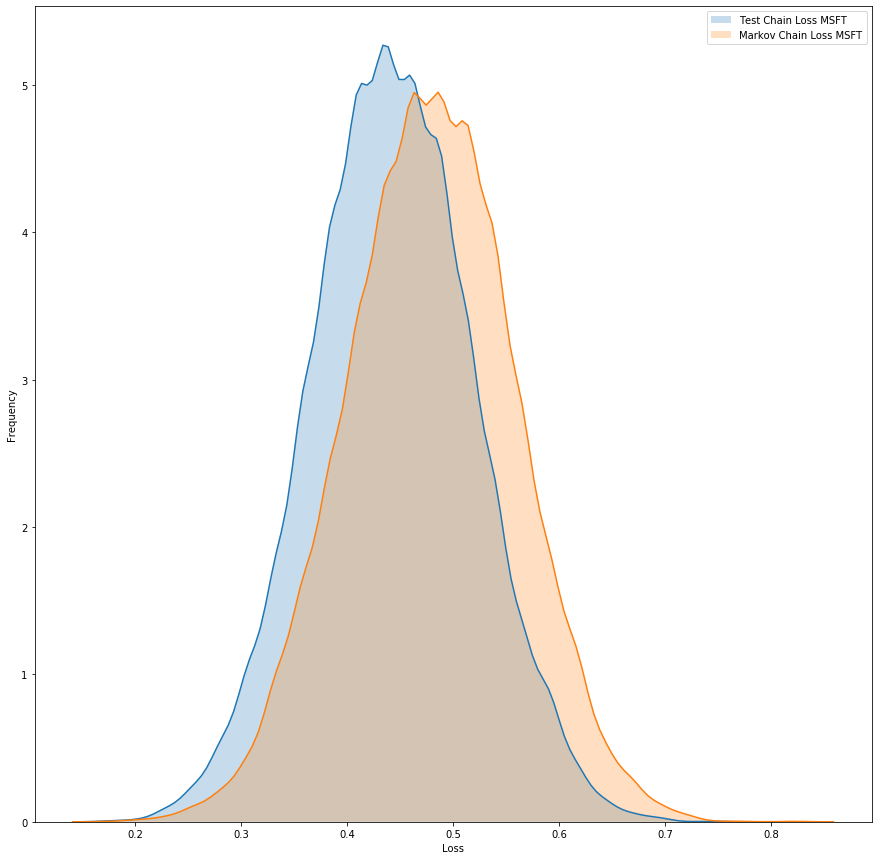

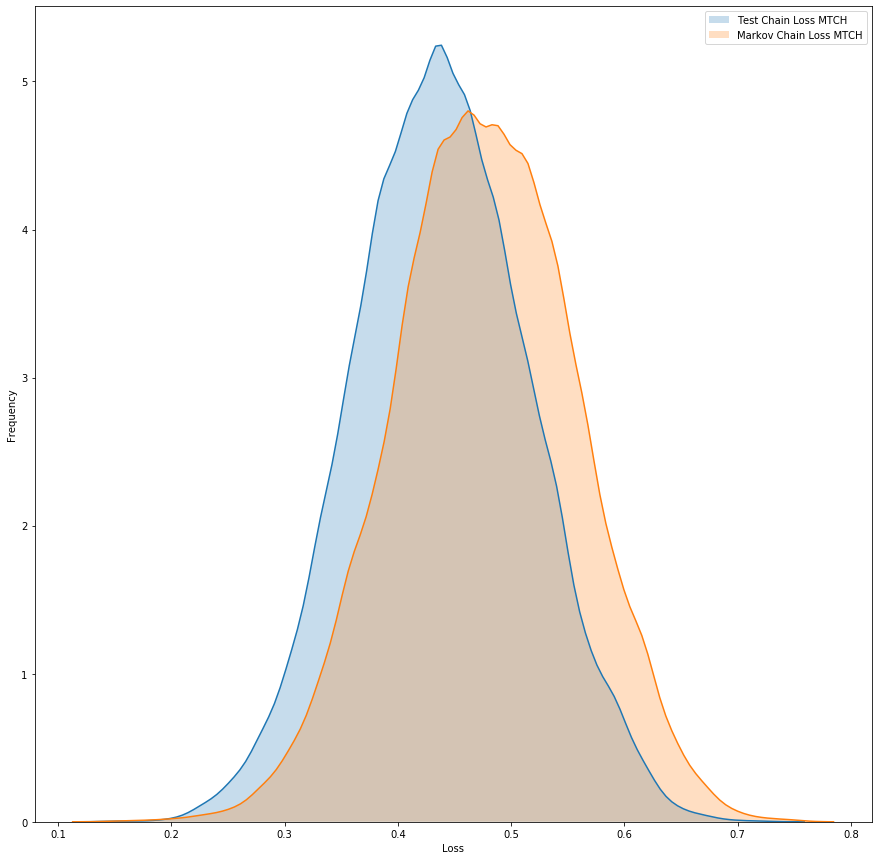

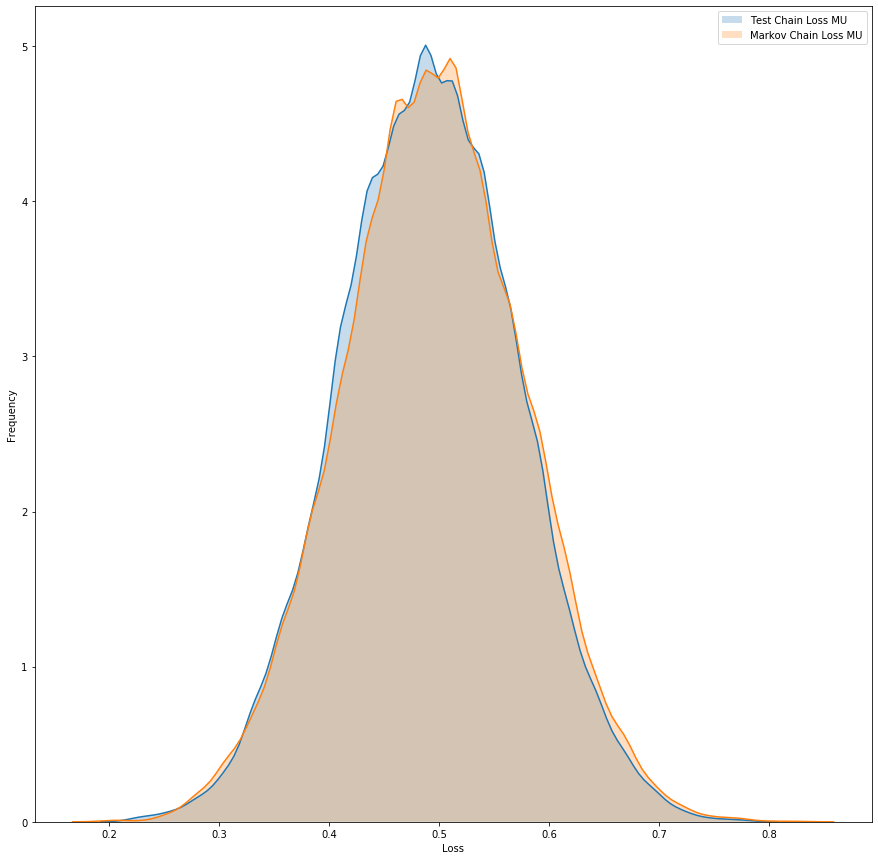

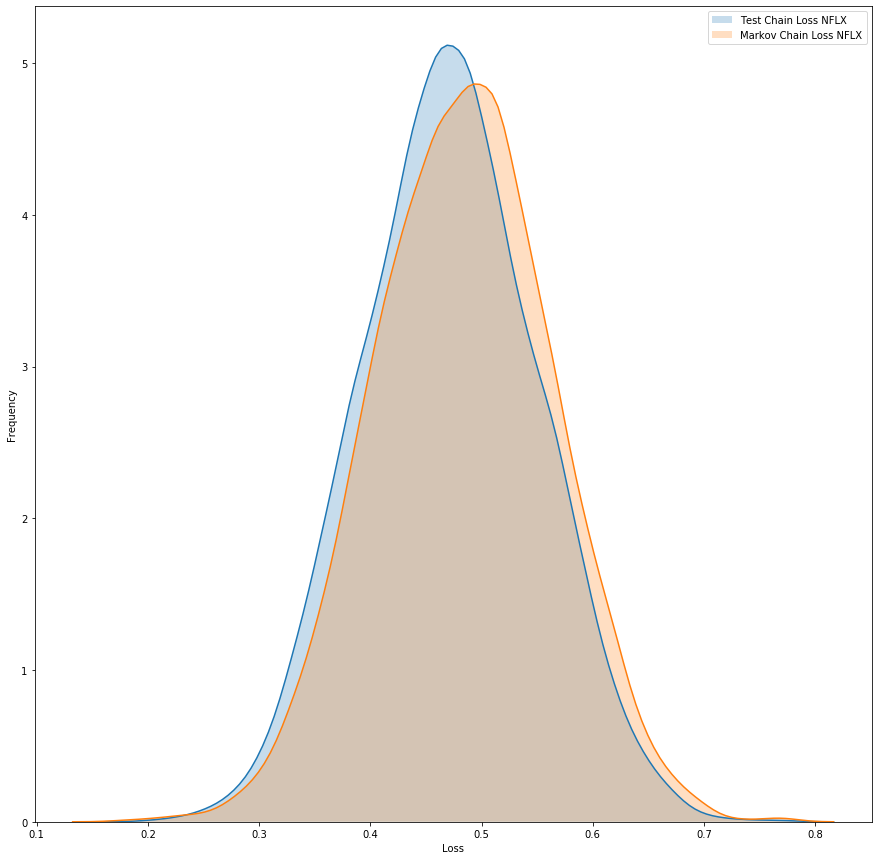

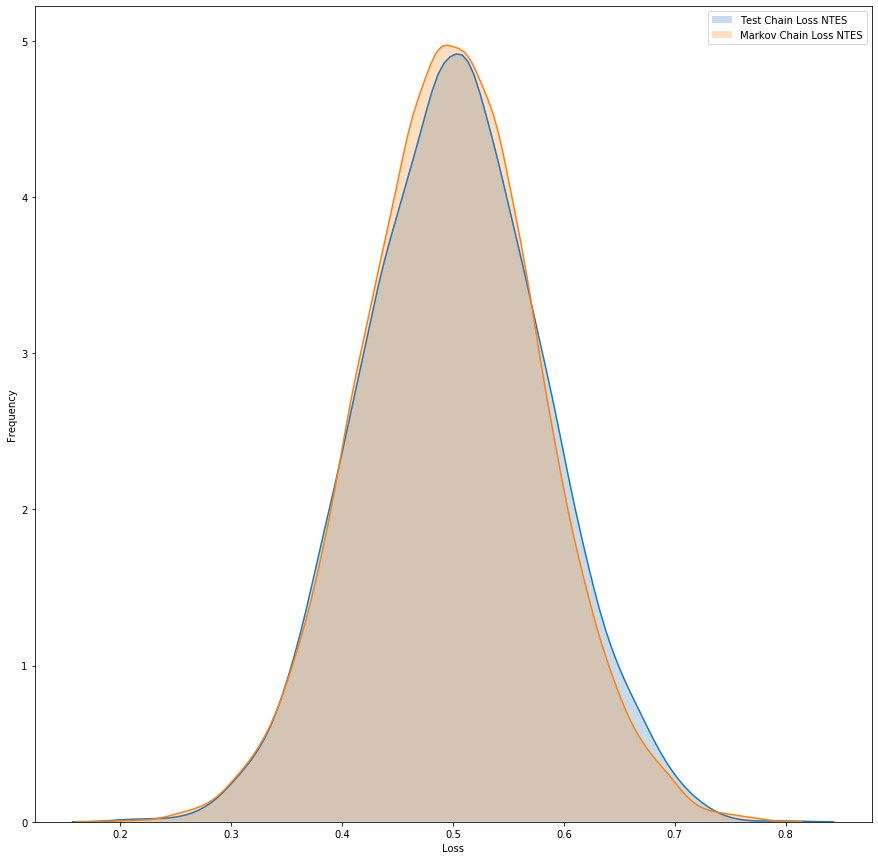

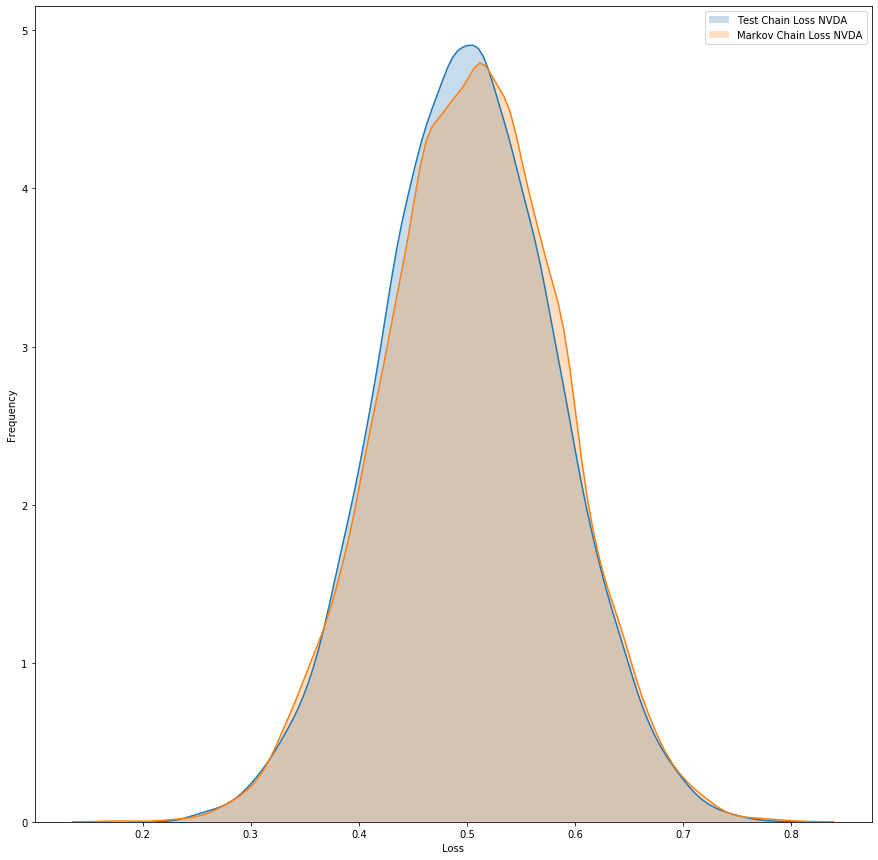

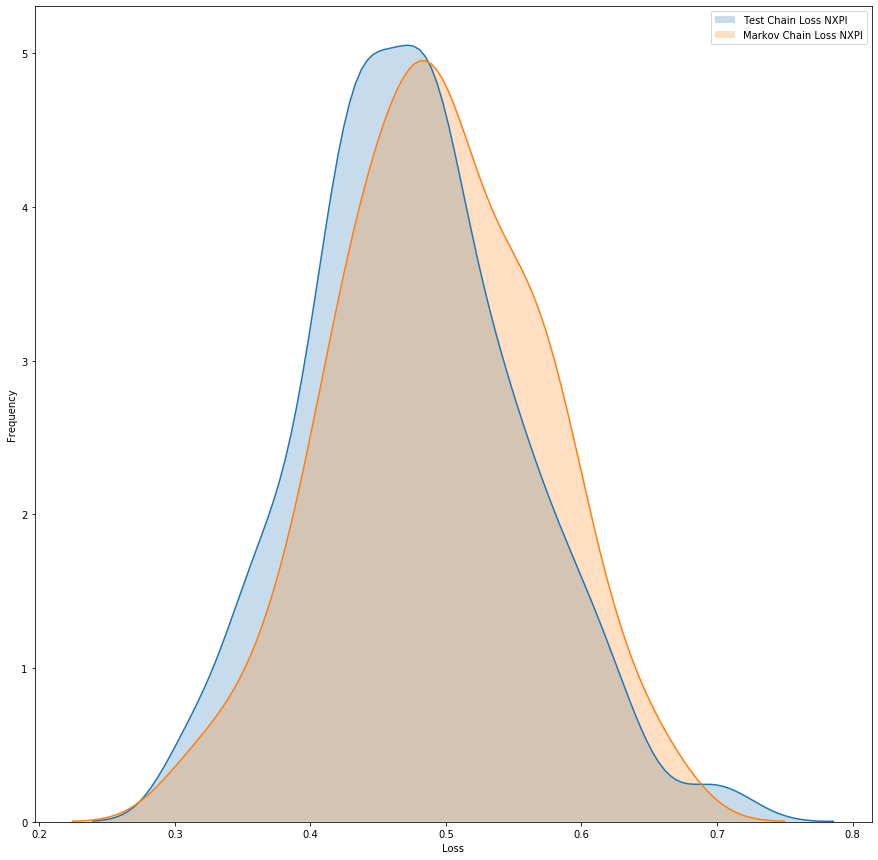

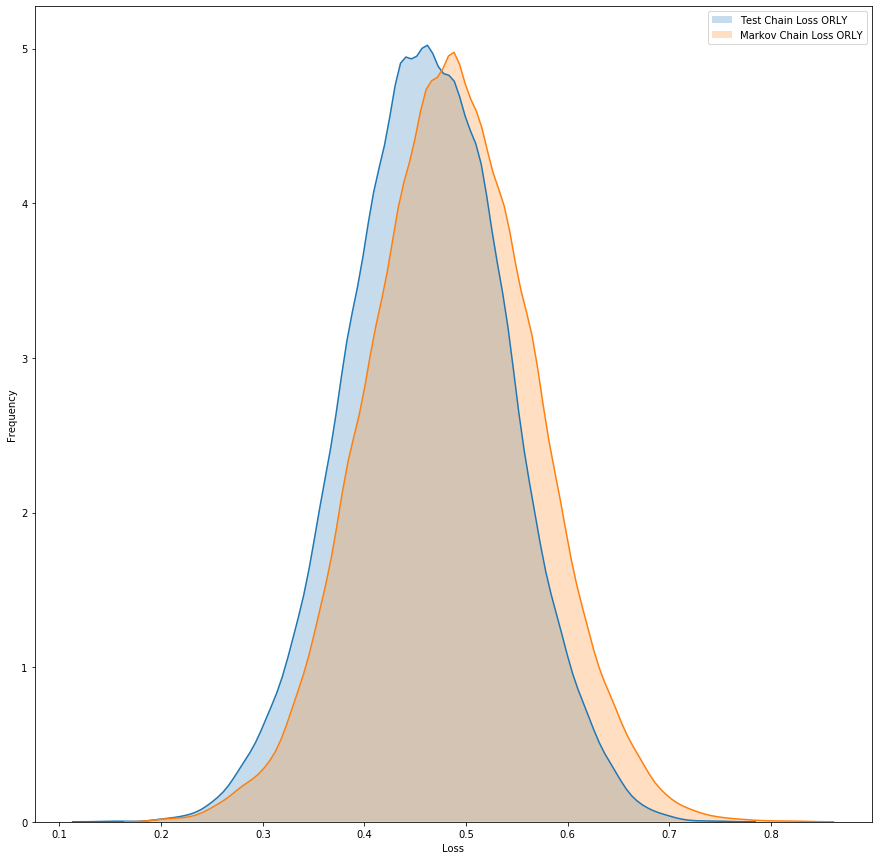

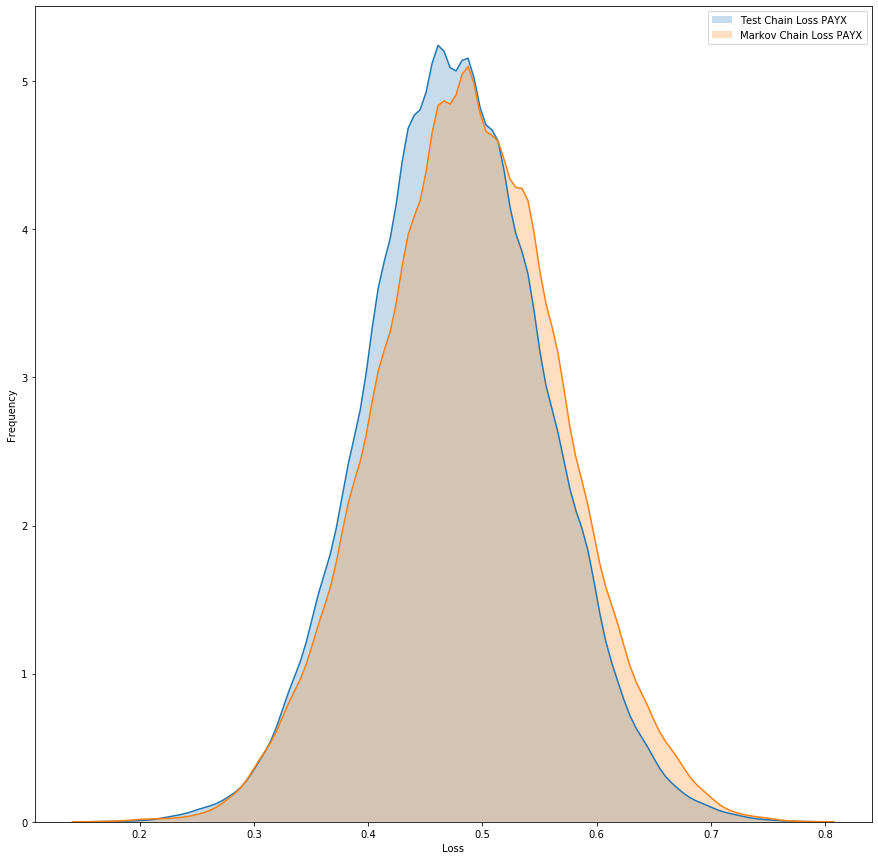

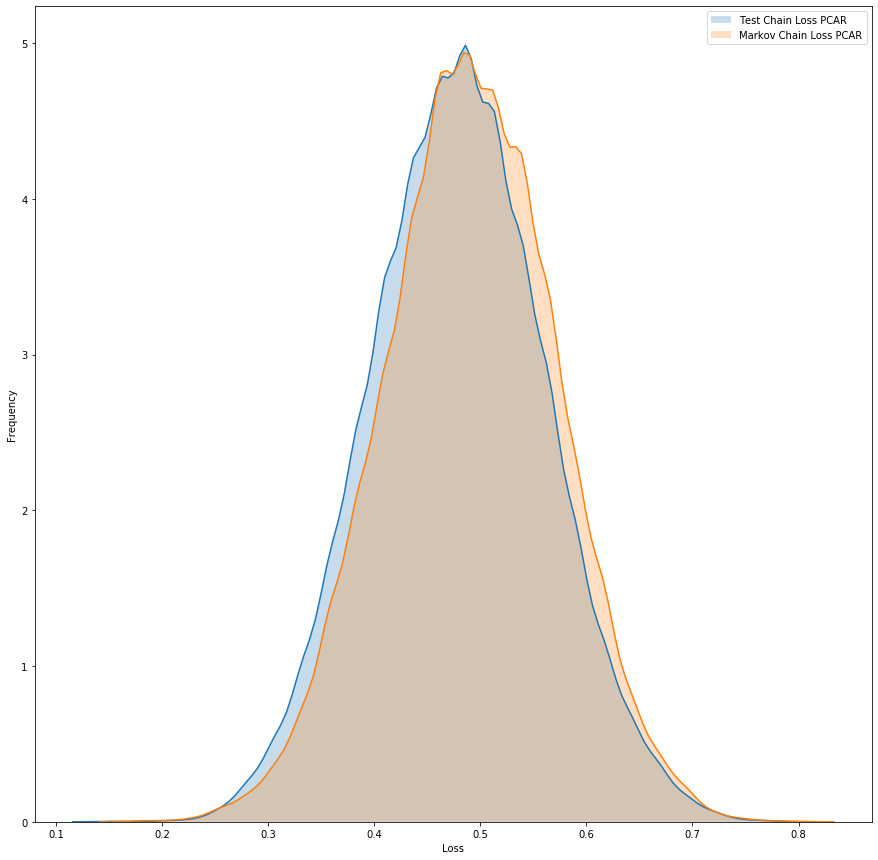

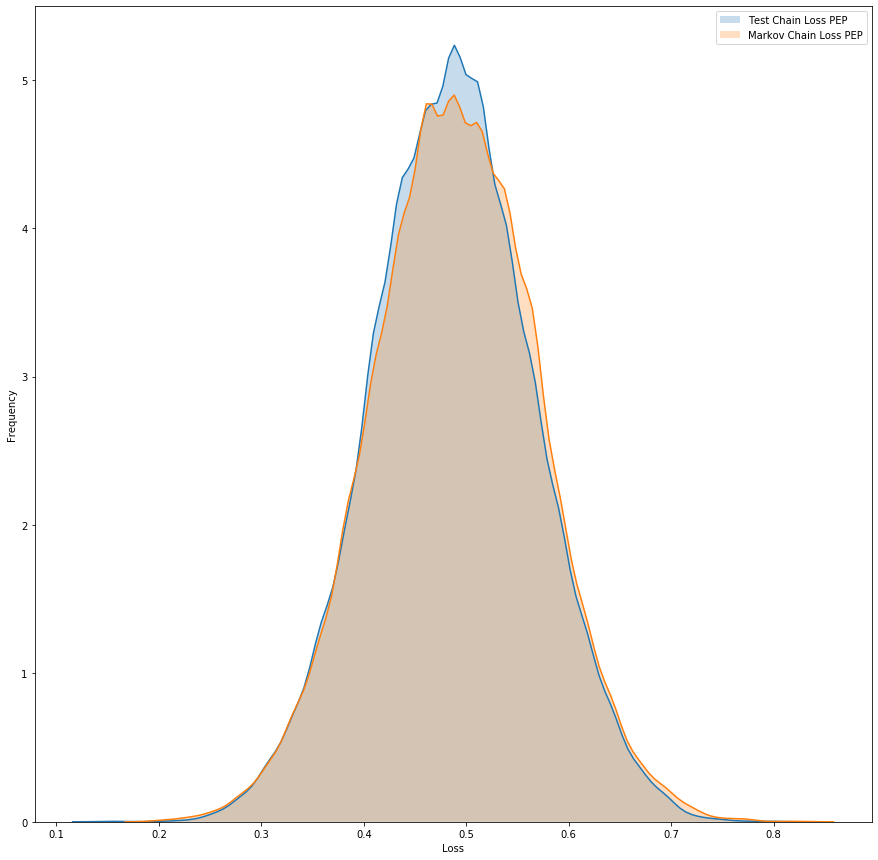

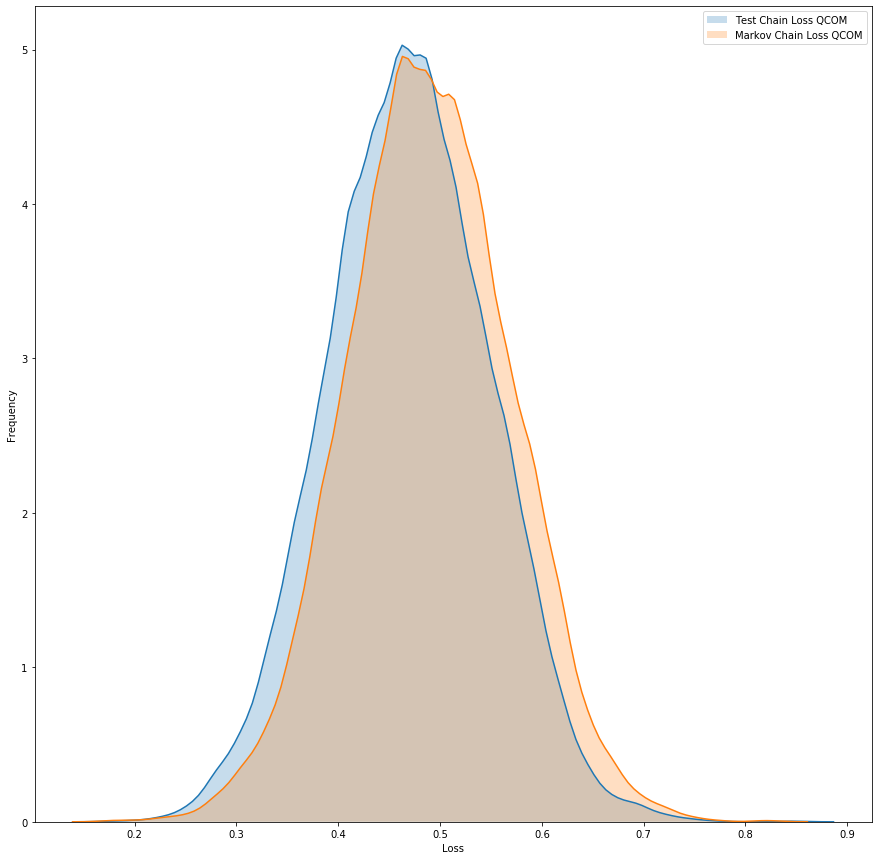

80.95238095238095% done!


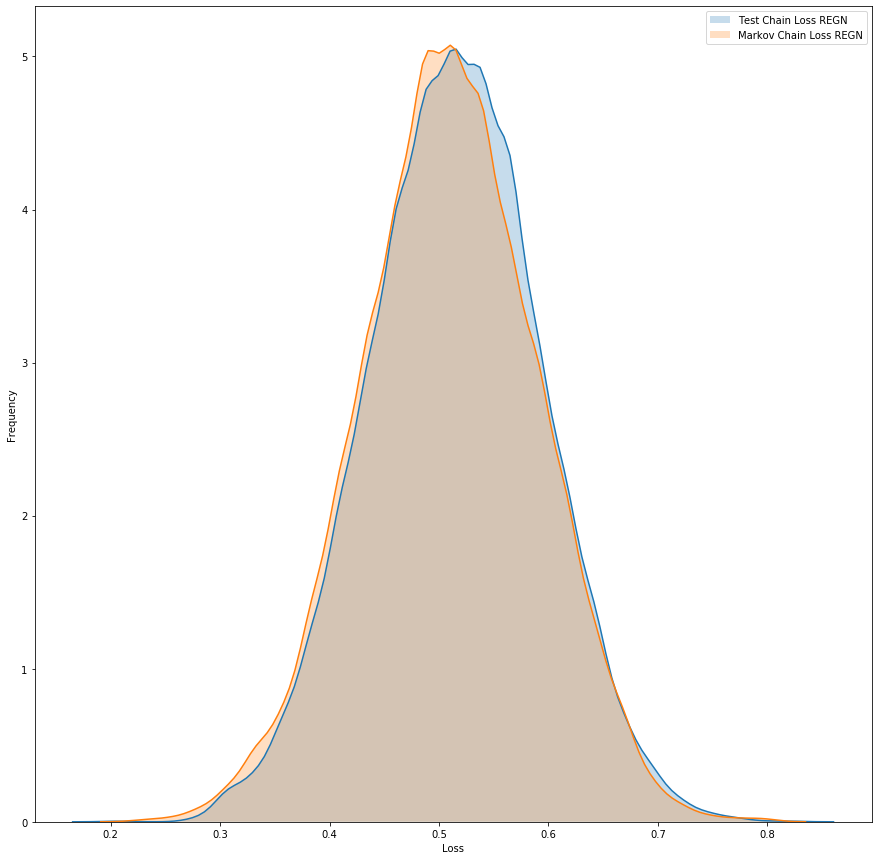

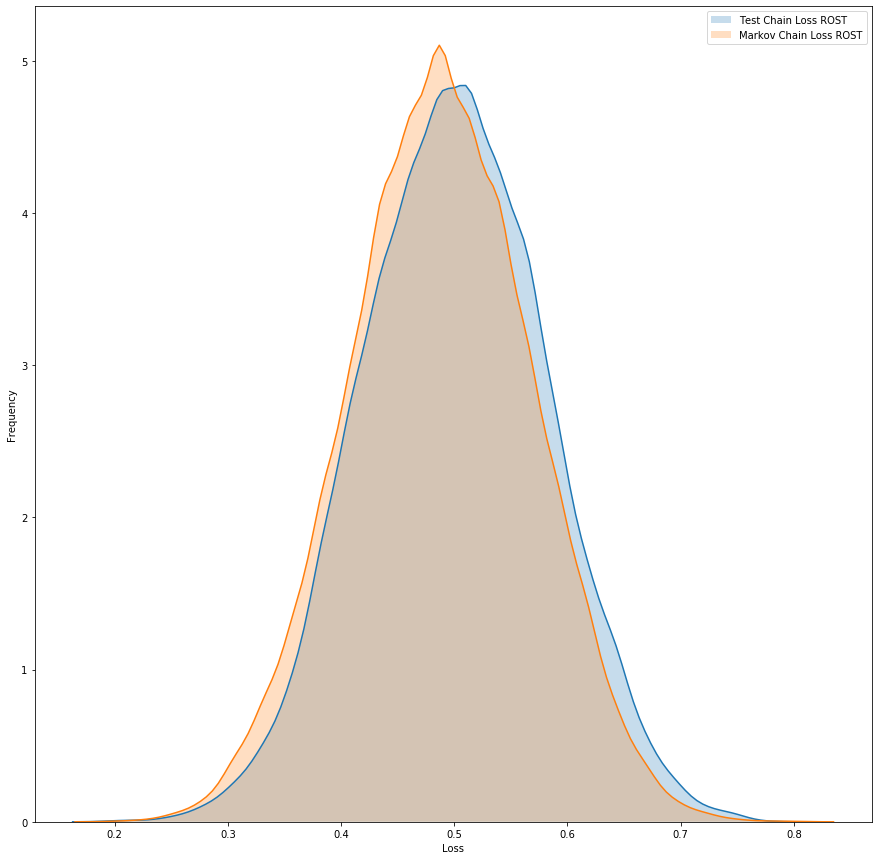

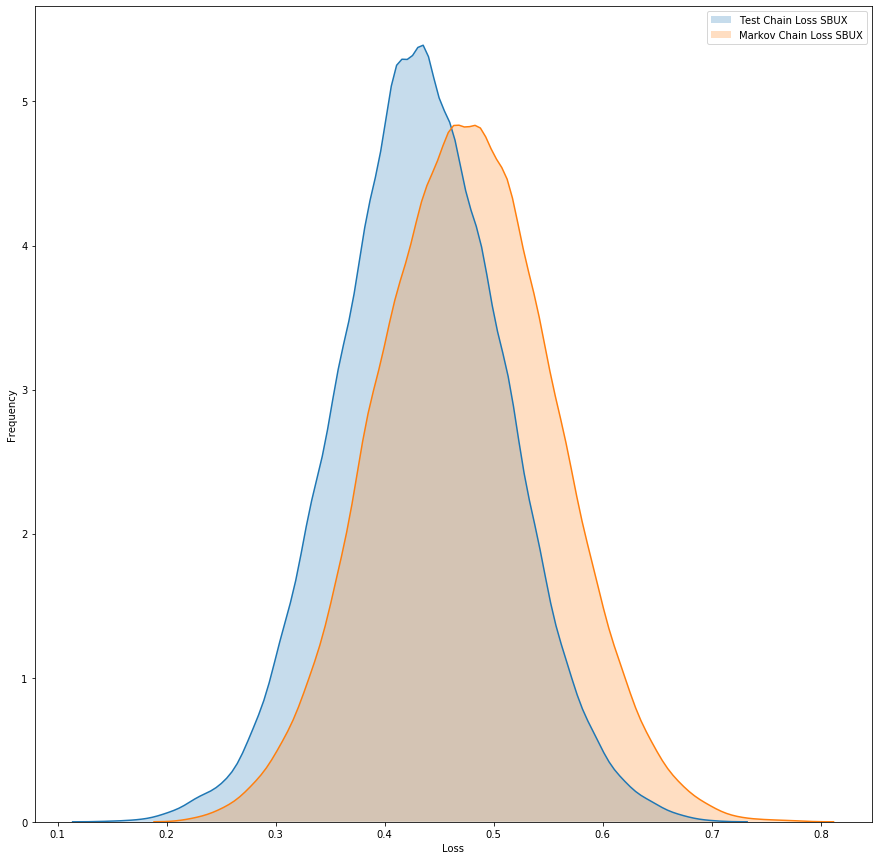

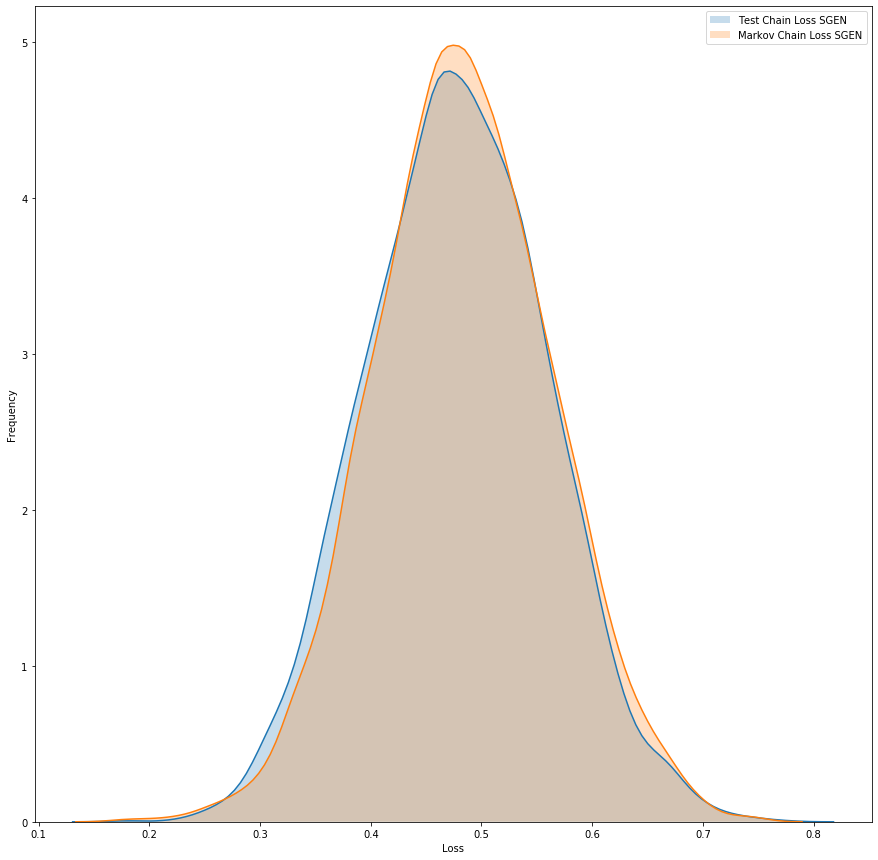

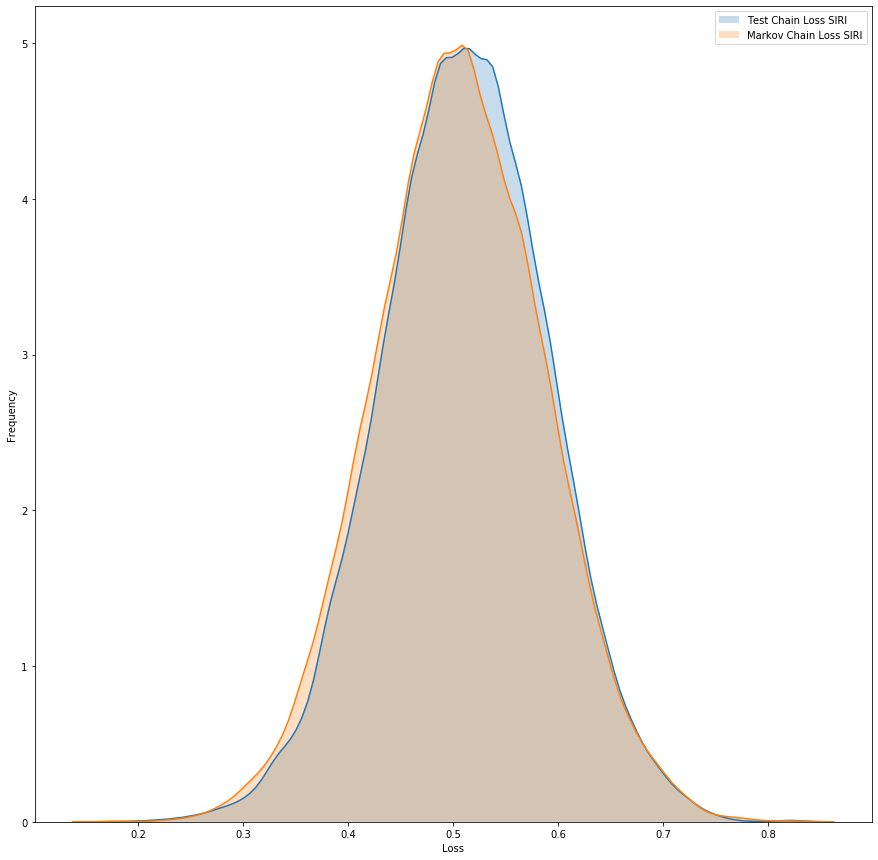

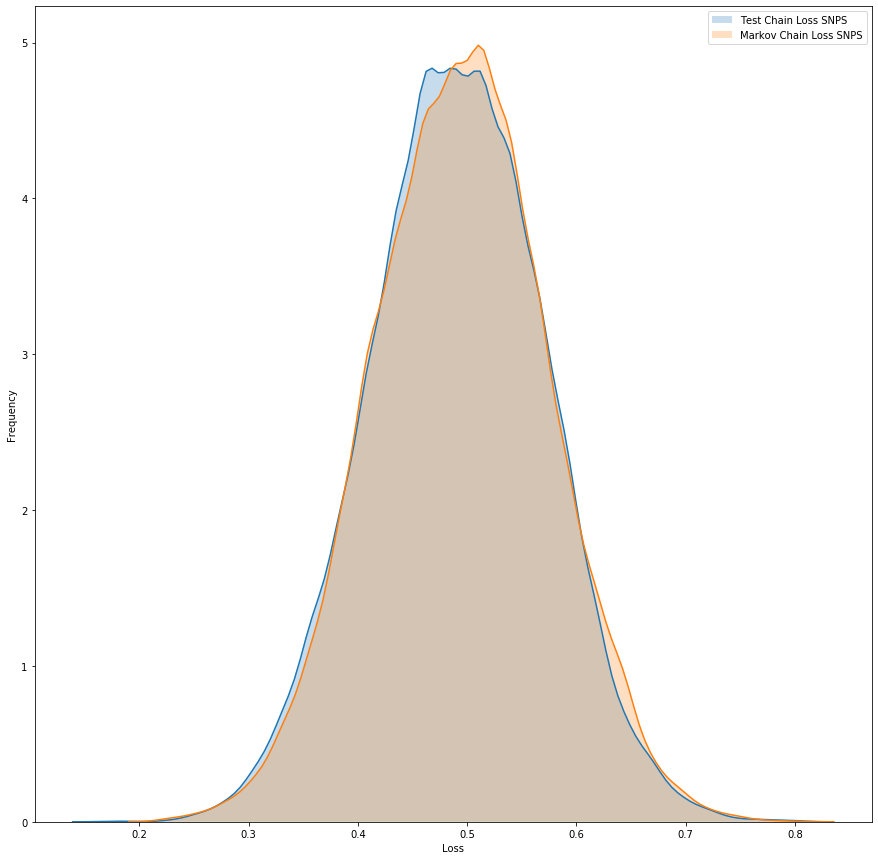

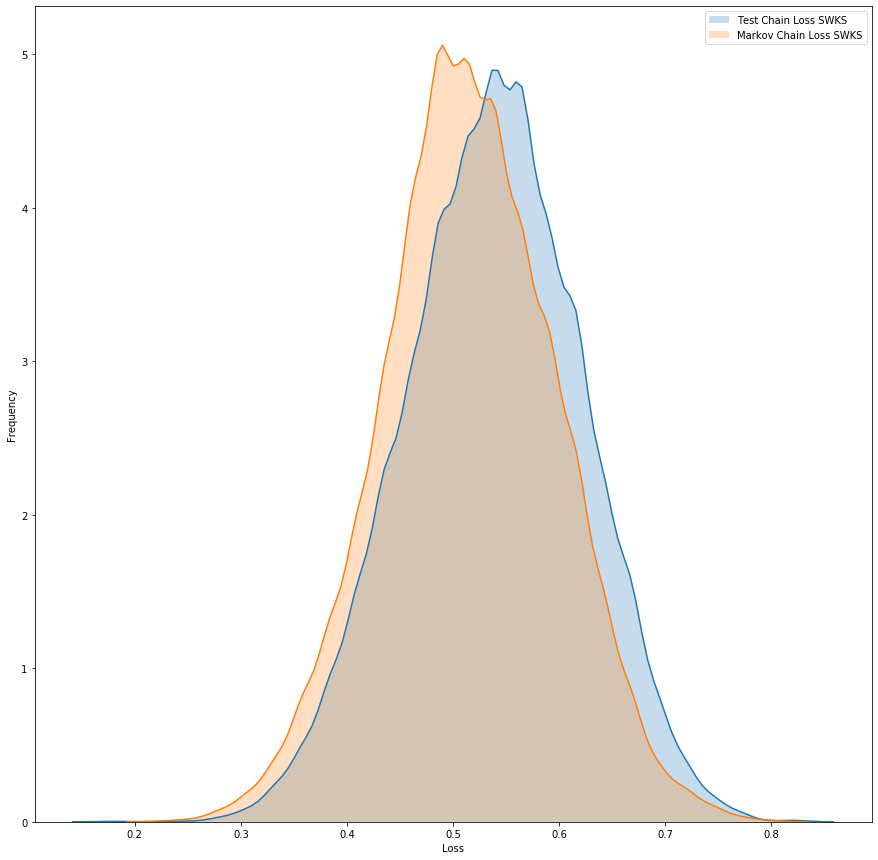

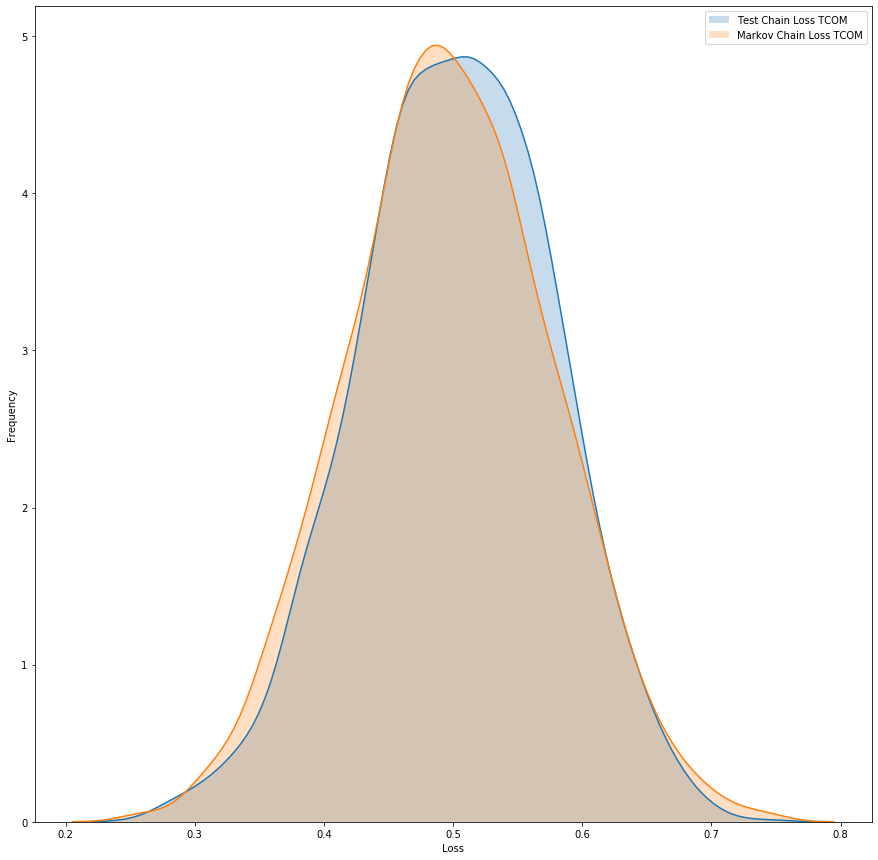

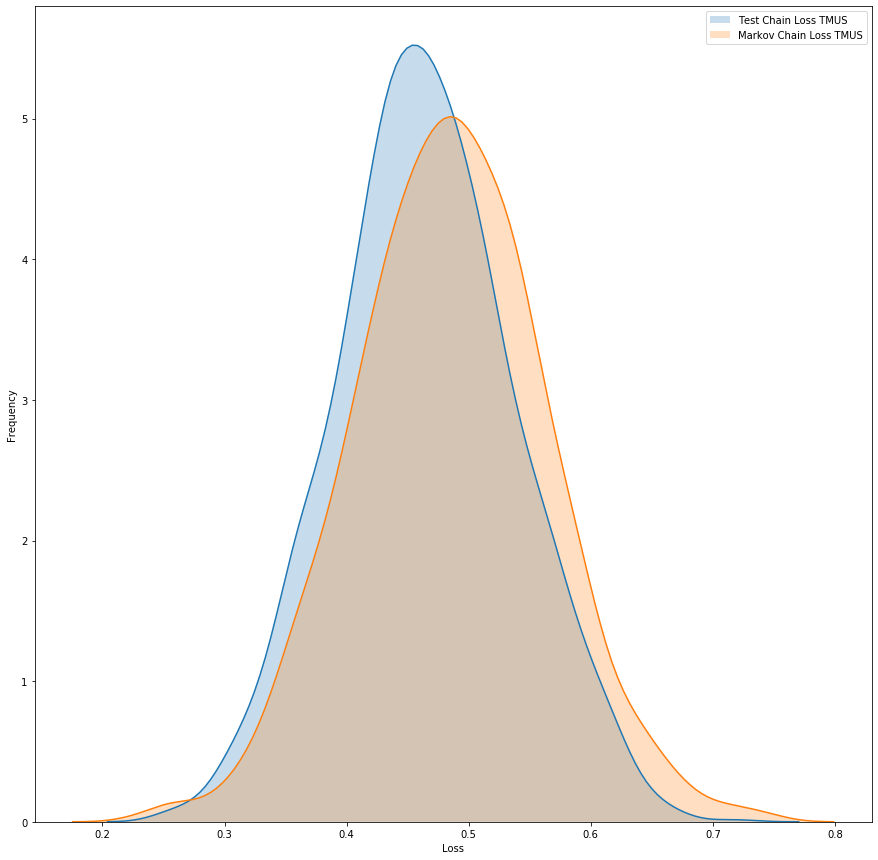

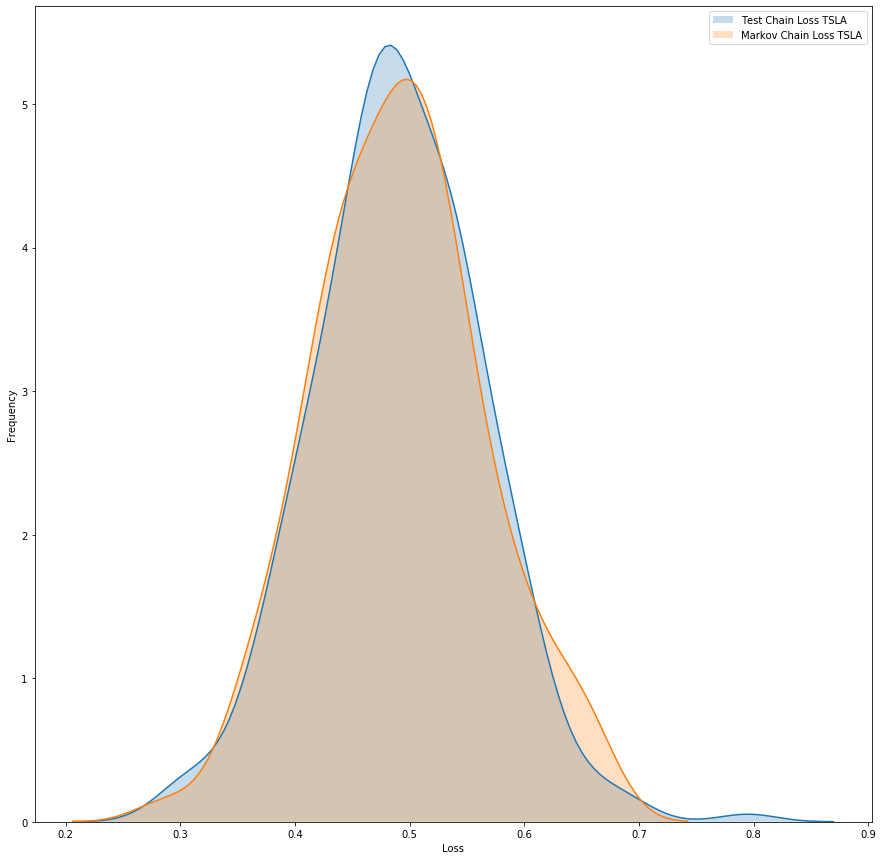

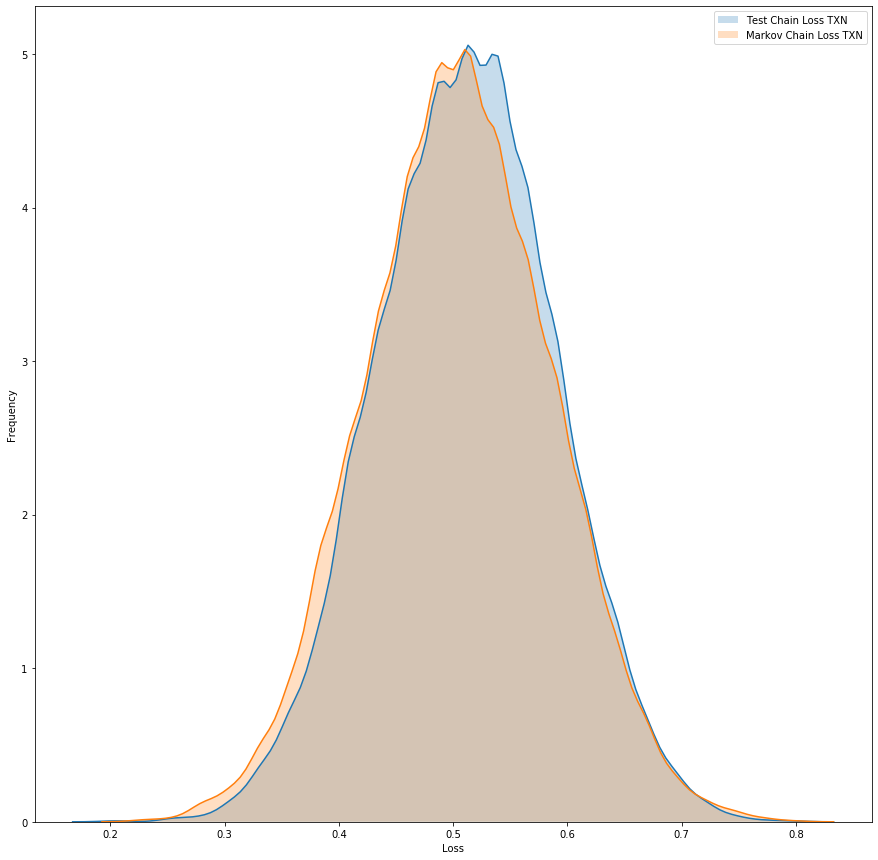

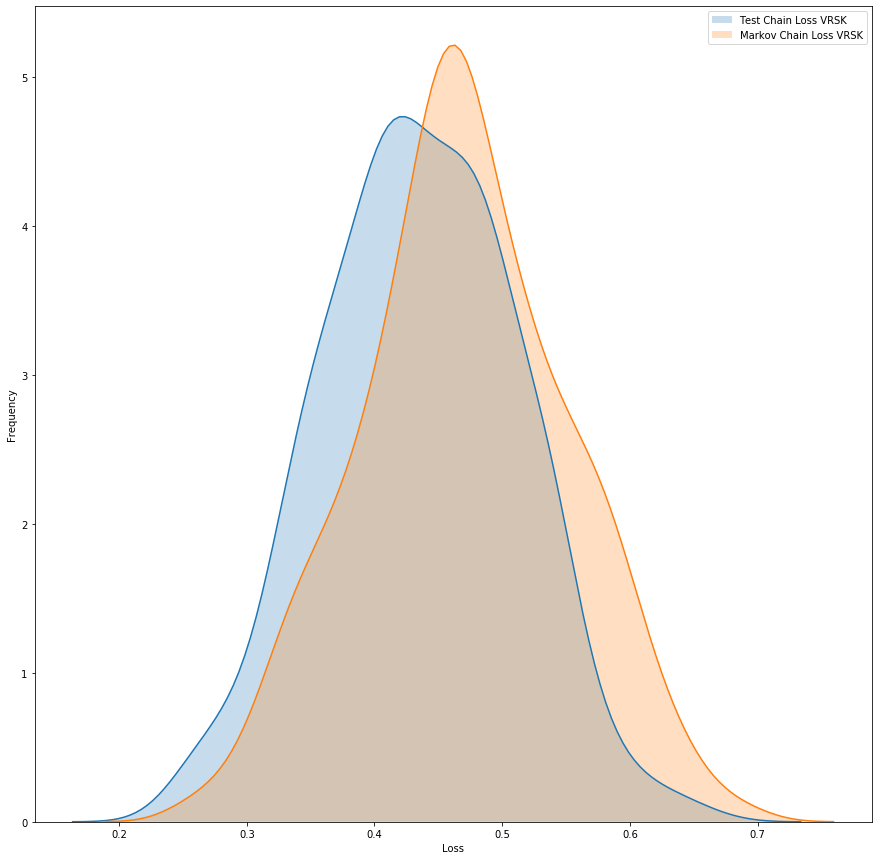

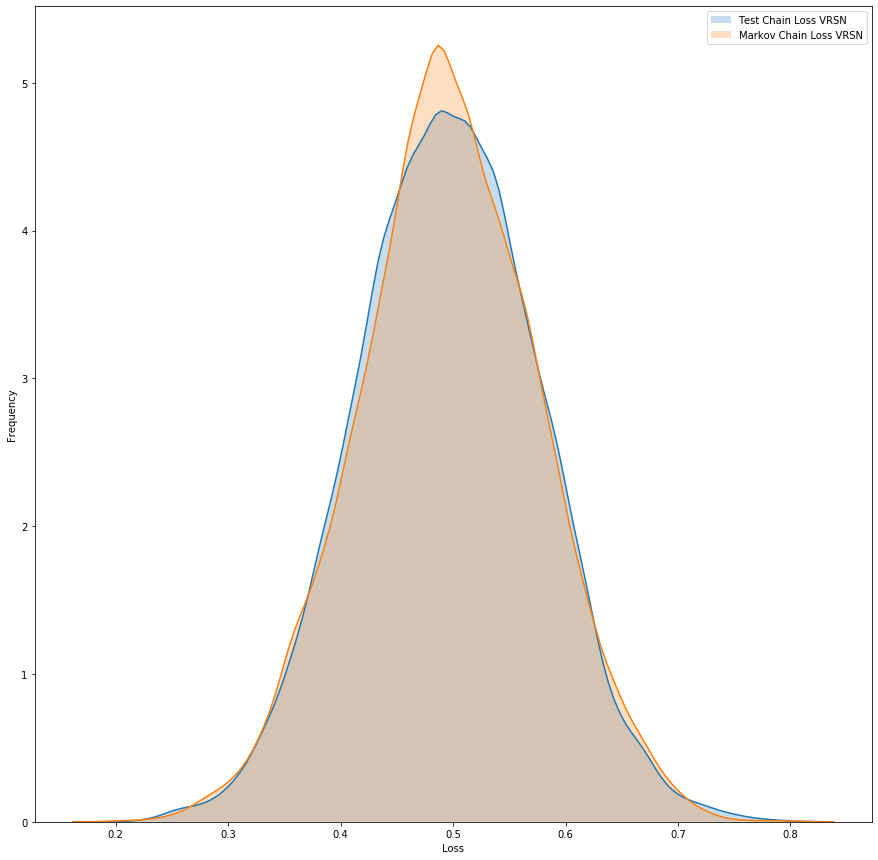

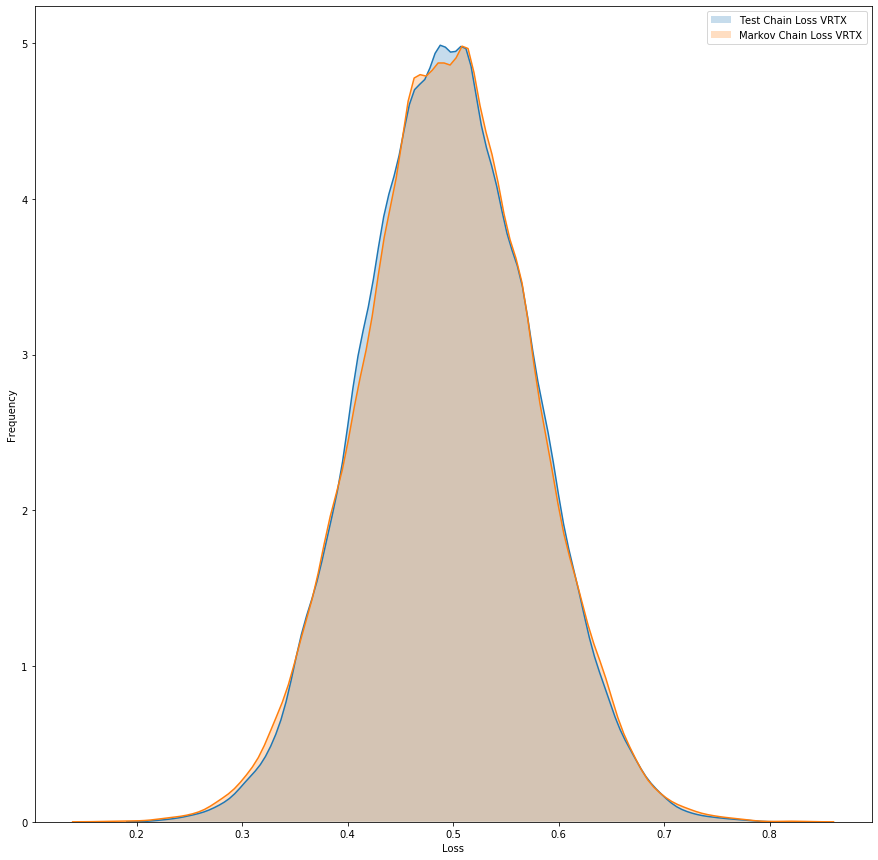

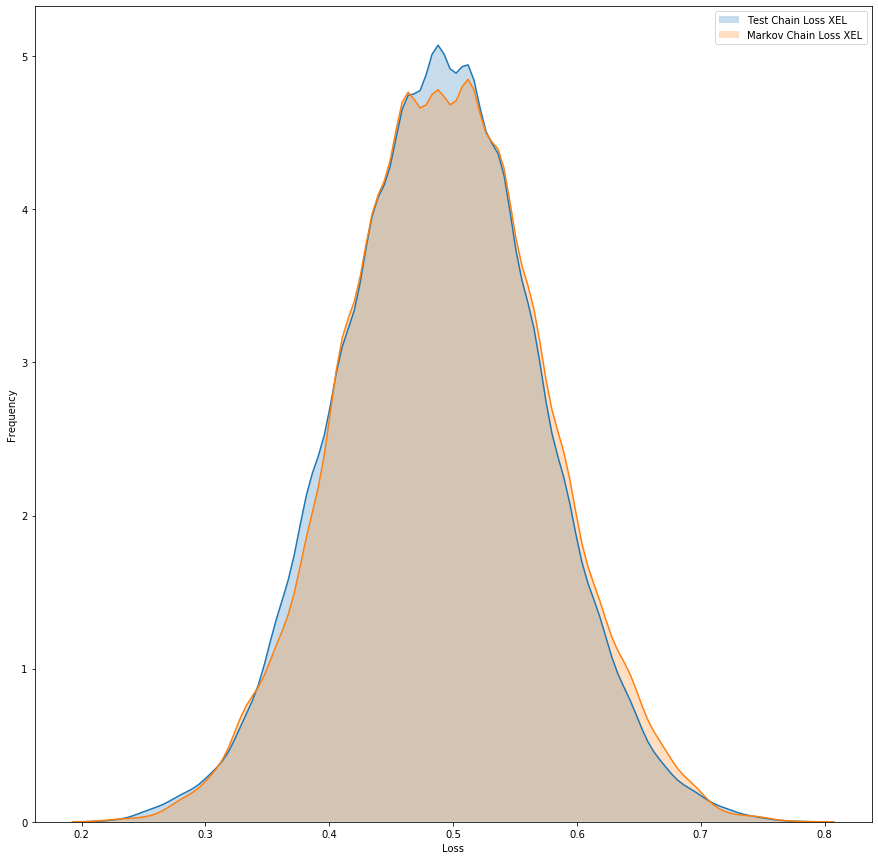

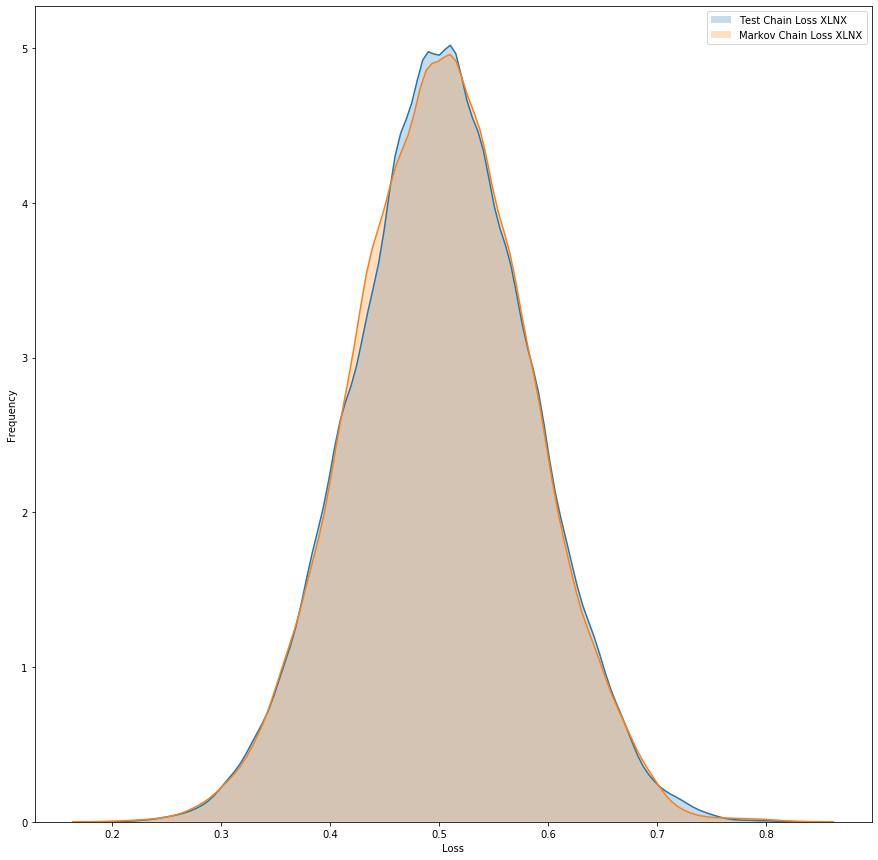

In [9]:
final_out = pd.DataFrame()
final_out["Ticker"] = list(all_data.keys())
testerrorqties = {}
for g in range(len(all_data)):
    if g in [1,23,46,68]:
        print(str(100*g / len(all_data))+"% done!")
    test_comps = [list(all_data.keys())[g]]
    test = npdf.iloc[np.where(npdf["Ticker"] == test_comps[0])]
    train = npdf.iloc[np.where(npdf["Ticker"] != test_comps[0])]
    train.reset_index(drop = True,inplace = True)
    test.reset_index(drop = True,inplace = True)
    npdfu = train.loc[npdf["t0"] == 1]
    npdfd = train.loc[npdf["t0"] == 0]
    n_neighbors = 10
    scale = pd.DataFrame()
    scale["MarketCap"] = norm(npdfu["MarketCap"])
    scale["PeRatio"] = norm(npdfu["PeRatio"])
    upknn = neighbors.KNeighborsClassifier(n_neighbors)
    X = scale[["MarketCap","PeRatio"]]
    y = npdfu["t1"]
    upknn.fit(X,y)
    scale = pd.DataFrame()
    scale["MarketCap"] = norm(npdfd["MarketCap"])
    scale["PeRatio"] = norm(npdfd["PeRatio"])
    downknn = neighbors.KNeighborsClassifier(n_neighbors)
    X = scale[["MarketCap","PeRatio"]]
    y = npdfd["t1"]
    downknn.fit(X,y)
    p = 40
    k = 0
    TEST1 = {}
    test1 = test.loc[test["Ticker"] == test_comps[0]][["t0","t1","PeRatio","MarketCap"]]
    test1.reset_index(drop = True,inplace = True)
    i=0
    while p+k <= len(test1):
        TEST1[i] = test1.iloc[k:p+k]
        k+=1
        i+=1
    np.random.seed(10)
    testloss = []
    n = 100
    for j in range(len(TEST1)):
        for i in range(n):
            out = proj(TEST1[j],"PeRatio","MarketCap",len(TEST1[j]),"t0")
            testloss.append(hamming_loss(out[1:],TEST1[j]["t1"][1:]))
    TM = pd.DataFrame(index = [1,0])

    tm = {"UU":0,"UD":0,"DU":0,"DD":0}

    for x in all_data.keys():
        if x not in test_comps:
            tm["UU"] += all_tm[x]["Up"]["Up"]
            tm["DU"] += all_tm[x]["Down"]["Up"]
            tm["UD"] += all_tm[x]["Up"]["Down"]
            tm["DD"] += all_tm[x]["Down"]["Down"]
    TM[1] = [tm["UU"],tm["UD"]]
    TM[0] = [tm["DU"],tm["DD"]]
    TM = scaleMatrix(TM)
    np.random.seed(10)
    ptstest1 = {}
    for i in range(len(TEST1)):
        ptstest1[i] = pd.DataFrame()
        ptstest1[i]["t0"] = [TEST1[i]["t0"][0]]
    ptsloss = []
    for j in range(len(TEST1)):
        for i in range(n):
            out = chain(init_state = ptstest1[j], matrix = TM, original_states = [1,0], init_state_col = "t0",n=len(TEST1[j])-1)
            ptsloss.append(hamming_loss(out.iloc[0][1:],TEST1[j]["t1"][1:]))
    f = plt.figure(g)
    f.set_figwidth(15)
    f.set_figheight(15)
    sns.kdeplot(testloss,shade=True)
    sns.kdeplot(ptsloss,shade=True)
    plt.xlabel("Loss")
    plt.ylabel("Frequency")
    plt.legend(["Test Chain Loss "+str(test_comps[0]),"Markov Chain Loss "+str(test_comps[0])])
    plt.show()
    testerrorqties[test_comps[0]] = {"Proposed Model":[x for x in pd.Series(testloss).describe(percentiles = [0.1+0.1*i for i in range(9)])],"Pure Time Series":[x for x in pd.Series(ptsloss).describe(percentiles = [0.1+0.1*i for i in range(9)])]}

In [10]:
testerrorqties

{'AAPL': {'Proposed Model': [10300.0,
   0.5029798356982803,
   0.0802896595340176,
   0.20512820512820512,
   0.41025641025641024,
   0.4358974358974359,
   0.46153846153846156,
   0.4871794871794871,
   0.5128205128205128,
   0.5128205128205128,
   0.5384615384615384,
   0.5641025641025641,
   0.6153846153846154,
   0.8205128205128205],
  'Pure Time Series': [10300.0,
   0.5011127707244184,
   0.07986303733360506,
   0.23076923076923078,
   0.41025641025641024,
   0.4358974358974359,
   0.46153846153846156,
   0.4871794871794871,
   0.5128205128205128,
   0.5128205128205128,
   0.5384615384615384,
   0.5641025641025641,
   0.6153846153846154,
   0.8461538461538461]},
 'ADBE': {'Proposed Model': [9800.0,
   0.47254840397697695,
   0.07672051167090976,
   0.15384615384615385,
   0.38461538461538464,
   0.41025641025641024,
   0.4358974358974359,
   0.46153846153846156,
   0.46153846153846156,
   0.4871794871794871,
   0.5128205128205128,
   0.5384615384615384,
   0.5641025641025641,
  

In [11]:
{"count":0, 
 "mean":1,
 "std":2,
 "min":3,
 "0.1":4,
 "0.2":5,
 "0.3":6,
 "0.4":7,
 "0.5":8,
 "0.6":9,
 "0.7":10,
 "0.8":11,
 "0.9":12,
 "max":13}

{'count': 0,
 'mean': 1,
 'std': 2,
 'min': 3,
 '0.1': 4,
 '0.2': 5,
 '0.3': 6,
 '0.4': 7,
 '0.5': 8,
 '0.6': 9,
 '0.7': 10,
 '0.8': 11,
 '0.9': 12,
 'max': 13}

In [18]:
pctreductionloss = []
avgcap = []
avgpe = []
q = 12
for x in testerrorqties.keys():
    l = (testerrorqties[x]["Pure Time Series"][q] - testerrorqties[x]["Proposed Model"][q]) / testerrorqties[x]["Pure Time Series"][q]
    pctreductionloss.append(l)
    print(l)
    avgcap.append(all_data[x]["MarketCap"][len(all_data[x])-1])
    avgpe.append(all_data[x]["PeRatio"][len(all_data[x])-1])
lossdf = pd.DataFrame()
lossdf["Reduction"] = pctreductionloss
lossdf["Average MktCap"] = avgcap
lossdf["Average P/E"] = avgpe
lossdf.head()

0.0
0.04347826086956525
0.0
0.0
0.0
0.09090909090909098
0.04347826086956525
0.0
0.0
0.0
0.0
0.04347826086956525
0.0
0.0
0.0416666666666667
0.0
0.04347826086956525
0.0
0.0869565217391305
0.0
0.04347826086956525
0.0
0.04347826086956525
-0.04347826086956525
0.0
0.0
0.04347826086956525
0.04347826086956525
0.0
0.0
0.04347826086956525
0.13043478260869576
0.0869565217391305
0.04347826086956525
0.13636363636363638
0.0
0.0869565217391305
0.0
0.04347826086956525
0.04347826086956525
0.04347826086956525
0.0
0.0
0.0
0.0
0.0
0.0869565217391305
0.0
0.0
-0.04347826086956525
0.0
0.0
0.0
0.04347826086956525
0.0
0.0
0.0869565217391305
0.0869565217391305
0.0
0.04347826086956525
-0.04347826086956525
0.0
0.0
0.04347826086956525
0.04347826086956525
0.0
0.0
0.04347826086956525
0.0
-0.04347826086956525
0.04545454545454549
0.0
0.0
0.0
-0.0416666666666667
0.0
0.04347826086956525
0.0
0.0
0.0869565217391305
0.0
0.0
0.0
0.0


Reduction  Average MktCap  Average P/E
0   0.000000       28.449760     3.422306
1   0.043478       26.208848     3.783121
2   0.000000       24.846344     3.687804
3   0.000000       25.155930     3.540466
4   0.000000       24.981045     4.007115

In [25]:
lossdf.loc[lossdf["Reduction"] <= 0].describe()

Reduction  Average MktCap  Average P/E
count  53.000000       53.000000    53.000000
mean   -0.004068       25.041695     3.795414
std     0.012725        1.050566     0.876705
min    -0.043478       23.355693     2.236873
25%     0.000000       24.316776     3.276579
50%     0.000000       24.846344     3.655271
75%     0.000000       25.458912     4.068514
max     0.000000       28.449760     6.511701

In [24]:
lossdf.loc[lossdf["Reduction"] > 0].describe()

Reduction  Average MktCap  Average P/E
count  31.000000       31.000000    31.000000
mean    0.060633       25.077094     3.822804
std     0.027420        1.144236     0.970883
min     0.041667       23.450882     2.776892
25%     0.043478       24.413567     3.217897
50%     0.043478       24.634301     3.686852
75%     0.086957       25.774758     4.233398
max     0.136364       28.342449     8.026951

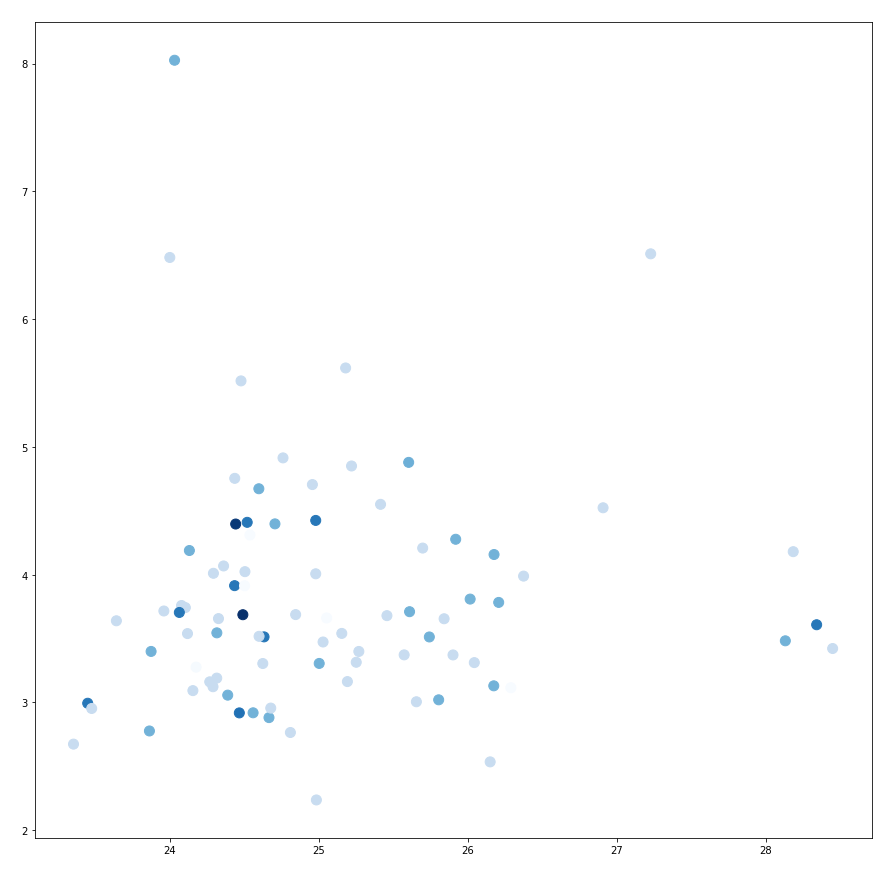

In [21]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)
plt.scatter(lossdf["Average MktCap"],lossdf["Average P/E"],c = lossdf["Reduction"],cmap="Blues",s = 100)
plt.xlabel("Market Cap",c="white")
plt.ylabel("P/E Ratio",c="white")
plt.title("Decrease in Loss",loc="left",c="white")
plt.show()

In [22]:
lossdf["Reduction"].describe(percentiles = [0.1+0.1*i for i in range(9)])

count    84.000000
mean      0.019810
std       0.036874
min      -0.043478
10%       0.000000
20%       0.000000
30%       0.000000
40%       0.000000
50%       0.000000
60%       0.000000
70%       0.043478
80%       0.043478
90%       0.086957
max       0.136364
Name: Reduction, dtype: float64

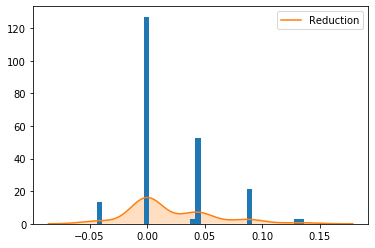

In [23]:
plt.hist(lossdf["Reduction"],density=True,bins=40)
sns.kdeplot(lossdf["Reduction"],shade=True)
plt.show()

In [26]:
findf

0         name        MarketCap  EnterpriseValue    PeRatio ForwardPeRatio  \
2   07/31/2021  112,281,272,082  107,694,602,082    130.379         84.034   
3   04/30/2021   94,117,182,263   89,978,485,263    142.031         84.746   
4   01/31/2021  108,603,290,918  106,801,731,918    258.382        117.647   
5   10/31/2020  131,092,473,891  129,683,306,891     583.43        140.845   
6   07/31/2020   72,197,459,780   71,163,803,780  1,422.075            200   
7   04/30/2020   38,116,860,126   37,334,133,126  1,501.889        322.581   
8   01/31/2020   21,266,935,794   20,511,392,794  1,399.743        222.222   
9   10/31/2019   19,305,467,149   18,603,582,149  1,599.094        357.143   
10  07/31/2019   26,120,663,809   25,435,230,809  2,335.322      1,666.667   
11  04/30/2019   19,736,252,388   19,559,851,388  2,415.667            NaN   

0  PegRatio  PsRatio  PbRatio EnterprisesValueRevenueRatio  \
2     4.375   34.667   26.786                      105.428   
3     5.082   35.933   24.378                       94.096   
4     1.631   56.342   72.818                      121.024   
5     2.098  100.845  109.938                       166.86   
6     3.406   90.061   80.074                      107.252   
7     9.564   55.204   45.707                      113.766   
8      3.15   39.015   27.529                      108.958   
9       NaN   41.217   25.955                      111.671   
10      NaN   66.281   36.292                      174.422   
11      NaN   58.939  117.947                      160.342   

0  EnterprisesValueEBITDARatio  
2                      317.958  
3                      379.696  
4                      402.156  
5                      648.971  
6                      365.732  
7                    1,299.754  
8                    1,939.979  
9                    4,171.207  
10                   3,304.135  
11                   3,049.556